# Clustering race strategies

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from itertools import groupby
import pickle
import os
import math
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.mpl.rcParams['figure.figsize'] = (16, 10)

# Directory to store pickled dataframes
directory = './formula-1-race-data/dataframes/'

pd.options.mode.chained_assignment = None 

In [4]:
import matplotlib as mpl
mpl.rc("savefig", dpi=300)

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 

In [6]:
def read_from_pickle(directory, filename):
    df = pd.DataFrame()
    filepath = directory + filename
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
            
    return df

In [7]:
dr_stint = read_from_pickle(directory, "dr_stint.pickle")
dr_stint['year'] = dr_stint['year'].astype(int)
pirelli = read_from_pickle(directory, "pirelli.pickle")
dataset = pd.read_csv(directory + 'dataset.csv')

In [8]:
index_list = ['year', 'driverRef', 'name']
pirelli = pirelli[pirelli['name'] != 'German Grand Prix']

In [9]:
# Finishing position labels
results_trunc = read_from_pickle(directory, "results_trunc.pickle")

In [10]:
# Team names mapped to each driver
dcrm = read_from_pickle(directory, "dcrm.pickle")
dcrm = dcrm[['year', 'name', 'driverRef', 'constructorRef']]

In [11]:
dr_stint = pd.merge(dr_stint, dcrm, on=index_list, how='left')
dr_stint = pd.merge(dr_stint, results_trunc, on=index_list, how='left')

In [12]:
def get_clusters(df_one_race, index_list, max_dist):
    
    # Data prep (DF CONTAINS ONE ONE RACE ONLY)
    df = df_one_race.drop(index_list+['constructorRef', 'position'], axis=1)

    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    c, coph_dists = cophenet(Z, pdist(X))
    clusters = fcluster(Z, max_dist, criterion='distance')

    report = pd.DataFrame({"Number of clusters": len(set(clusters)), "c": c, 'max dist': max_dist}, index=[0])
    cl = pd.DataFrame(clusters, columns=['clusters'])
    cl['max dist'] = max_dist
    df_cl = pd.concat([df_one_race.reset_index(drop=True), cl], axis=1)
    
    return report, df_cl


In [13]:
def plot_dendogram(df_one_race, plot_title, filename):
    
    # Data prep (DF CONTAINS ONE ONE RACE ONLY)
    df = df_one_race.drop(index_list+['constructorRef', 'position'], axis=1)
    X = df.as_matrix(columns=None)

    Z = linkage(X, 'ward')
    
    # call dendrogram to get the returned dictionary (plotting parameters can be ignored at this point)
    R = dendrogram(
                Z,
                no_plot=True,
                )

    # create a label dictionary
    labels = df_one_race.driverRef
    temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])

    dendrogram(
        Z,
        leaf_label_func=llf,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
    
    plt.title(plot_title)
    plt.xlabel('Drivers')
    plt.ylabel('Distance')
    plt.savefig(directory+filename, bbox_inches='tight', facecolor='w', transparent=False, pad_inches = 0.5)
    plt.show()

In [29]:
def plot_clustermap(df, plot_title, filename):
    
    # Enable driver's names to act as index
    df = df.set_index('driverRef')
    del df.index.name
    
    # Add colored labels
    position = df.pop("position")
    pos = dict(zip(position.unique(), ['red', 'blue', 'green', 'yellow']))
    print pos
    row_colors = position.map(pos)
    
    g = sns.clustermap(df.drop(['year', 'name', 'constructorRef'], axis=1),
                   metric="euclidean", method="ward", row_colors=row_colors)
    plt.title(plot_title)
    g.fig.savefig(directory+filename, bbox_inches='tight', facecolor='w', transparent=False, pad_inches = 0.5)

In [36]:
def plot_clusters(df, row, col, scatter_x, scatter_y, hue, col_for_s, filename):
    
    g = sns.FacetGrid(df, row=row, col=col, hue=hue, aspect=1, size=4, palette='Set2')
    g.map(plt.scatter, scatter_x, scatter_y, alpha=0.8, edgecolor='white', linewidth=0.5, s=100+df[col_for_s]*20)
    fig = g.fig 
    fig.subplots_adjust(top=0.8, wspace=0.3)
    l = g.add_legend(title=hue)
    fig.savefig(directory+filename, bbox_inches='tight', facecolor='w', transparent=False, pad_inches = 0.5)

## Clustering each race individually

In [16]:
def get_clusters_per_race_loop(df, index_list, pirelli, category, max_dist, cols):
    
    df_report_all = pd.DataFrame()
    df_clusters_all = pd.DataFrame()

    p = pirelli[pirelli['mandatory combi'] == category].sort_values(['name', 'year'])
    p_races = p[['year', 'name']].to_dict('list')
    
    for k,v in zip(p_races['year'], p_races['name']):
        for i in max_dist:
            df_report, df_clusters = get_clusters(df[(df['year'] == k) & (df['name'] == v)][index_list+['constructorRef', 'position']+cols],
                                                  index_list, max_dist=i)
            df_report['year'] = k
            df_report['name'] = v
            df_report['max dist'] = i
            df_report_all = pd.concat([df_report_all, df_report])
            
            df_clusters['pirelli category'] = category
            df_clusters_all = pd.concat([df_clusters_all, df_clusters])
            
    return df_report_all, df_clusters_all

In [17]:
cat1 = ['1SS', '1S', '1M', '2SS', '2S', '2M', '3SS', '3S', '3M', '4SS', '4S', '4M'] # SS, S, M = 1, # S, M = 1
cat2 = ['1H', '1S', '1M', '2H', '2S', '2M', '3H', '3S', '3M', '4H', '4S', '4M'] # S, M, H = 2, # M, H = 2
cat3 = ['1SS', '1S', '1US', '2SS', '2S', '2US', '3SS', '3S', '3US', '4SS', '4S', '4US']  # SS, S, US = 3, # SS, S = 3

In [18]:
max_dist = [25,50,75,100]
df_report_cat1, df_clusters_cat1 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,1, max_dist, cat1)
df_report_cat2, df_clusters_cat2 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,2, max_dist, cat2)
df_report_cat3, df_clusters_cat3 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,3, max_dist, cat3)

/Users/dianaow/anaconda2/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:1280: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


### Visualize how a race is clustered

#### eg. 2016 Australian Grand Prix -> Pirelli Cat 1 race

In [19]:
SS = cat1[0::3]
S = cat1[1::3]
M = cat1[2::3]

In [20]:
aus = dr_stint[(dr_stint['year'] == 2016) & (dr_stint['name'] == 'Australian Grand Prix')]\
     [index_list+ cat1+['position', 'constructorRef']].reset_index(drop=True)
aus

,year,driverRef,name,1SS,1S,1M,2SS,2S,2M,3SS,3S,3M,4SS,4S,4M,position,constructorRef
0,2016,alonso,Australian Grand Prix,12.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Did not finish,mclaren
1,2016,bottas,Australian Grand Prix,0.0,17.0,0.0,0.0,0.0,2.0,0.0,0.0,39.0,0.0,0.0,0.0,Pos 4 to 10,williams
2,2016,button,Australian Grand Prix,0.0,15.0,0.0,0.0,3.0,0.0,12.0,0.0,0.0,0.0,0.0,26.0,Pos > 10,mclaren
3,2016,ericsson,Australian Grand Prix,11.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,Did not finish,sauber
4,2016,grosjean,Australian Grand Prix,0.0,18.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Pos 4 to 10,haas
5,2016,gutierrez,Australian Grand Prix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Did not finish,haas
6,2016,hamilton,Australian Grand Prix,16.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,39.0,0.0,0.0,0.0,Podium,mercedes
7,2016,haryanto,Australian Grand Prix,12.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Did not finish,manor
8,2016,hulkenberg,Australian Grand Prix,0.0,16.0,0.0,0.0,0.0,2.0,0.0,0.0,39.0,0.0,0.0,0.0,Pos 4 to 10,force_india
9,2016,magnussen,Australian Grand Prix,1.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,Pos > 10,renault


In [21]:
max_dist = [50,75,100]
df_aus = pd.DataFrame()
report_aus = pd.DataFrame()
for i in max_dist:
    df_report, df_clusters = get_clusters(aus, index_list, max_dist=i)
    df_aus = pd.concat([df_aus, df_clusters])
    report_aus = pd.concat([report_aus, df_report])

In [22]:
report_aus

,Number of clusters,c,max dist
0,4,0.839522,50
0,2,0.839522,75
0,2,0.839522,100


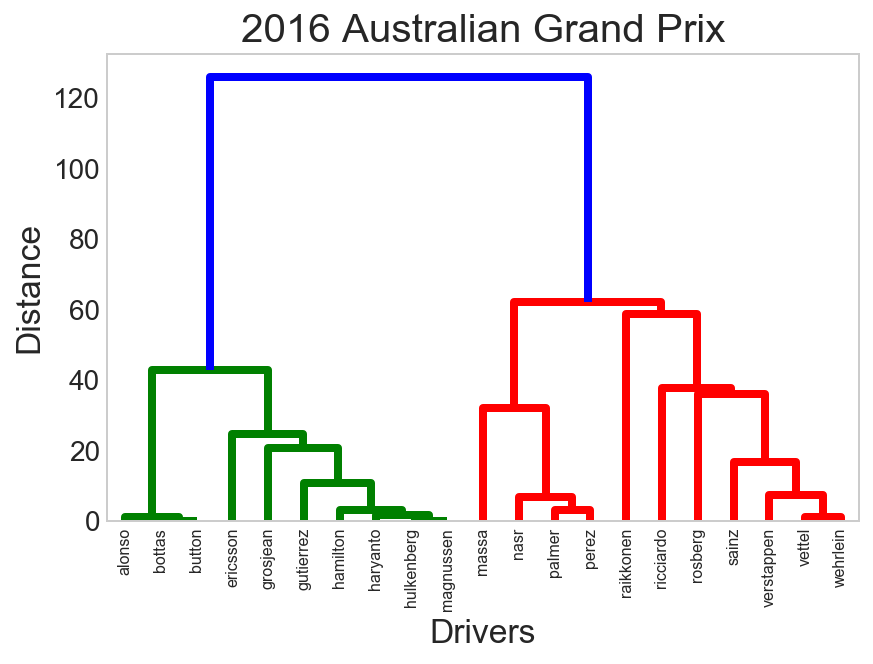

In [23]:
plot_dendogram(aus, '2016 Australian Grand Prix', 'aus_dendrogram.png')

{'Podium': 'yellow', 'Pos 4 to 10': 'blue', 'Pos > 10': 'green', 'Did not finish': 'red'}


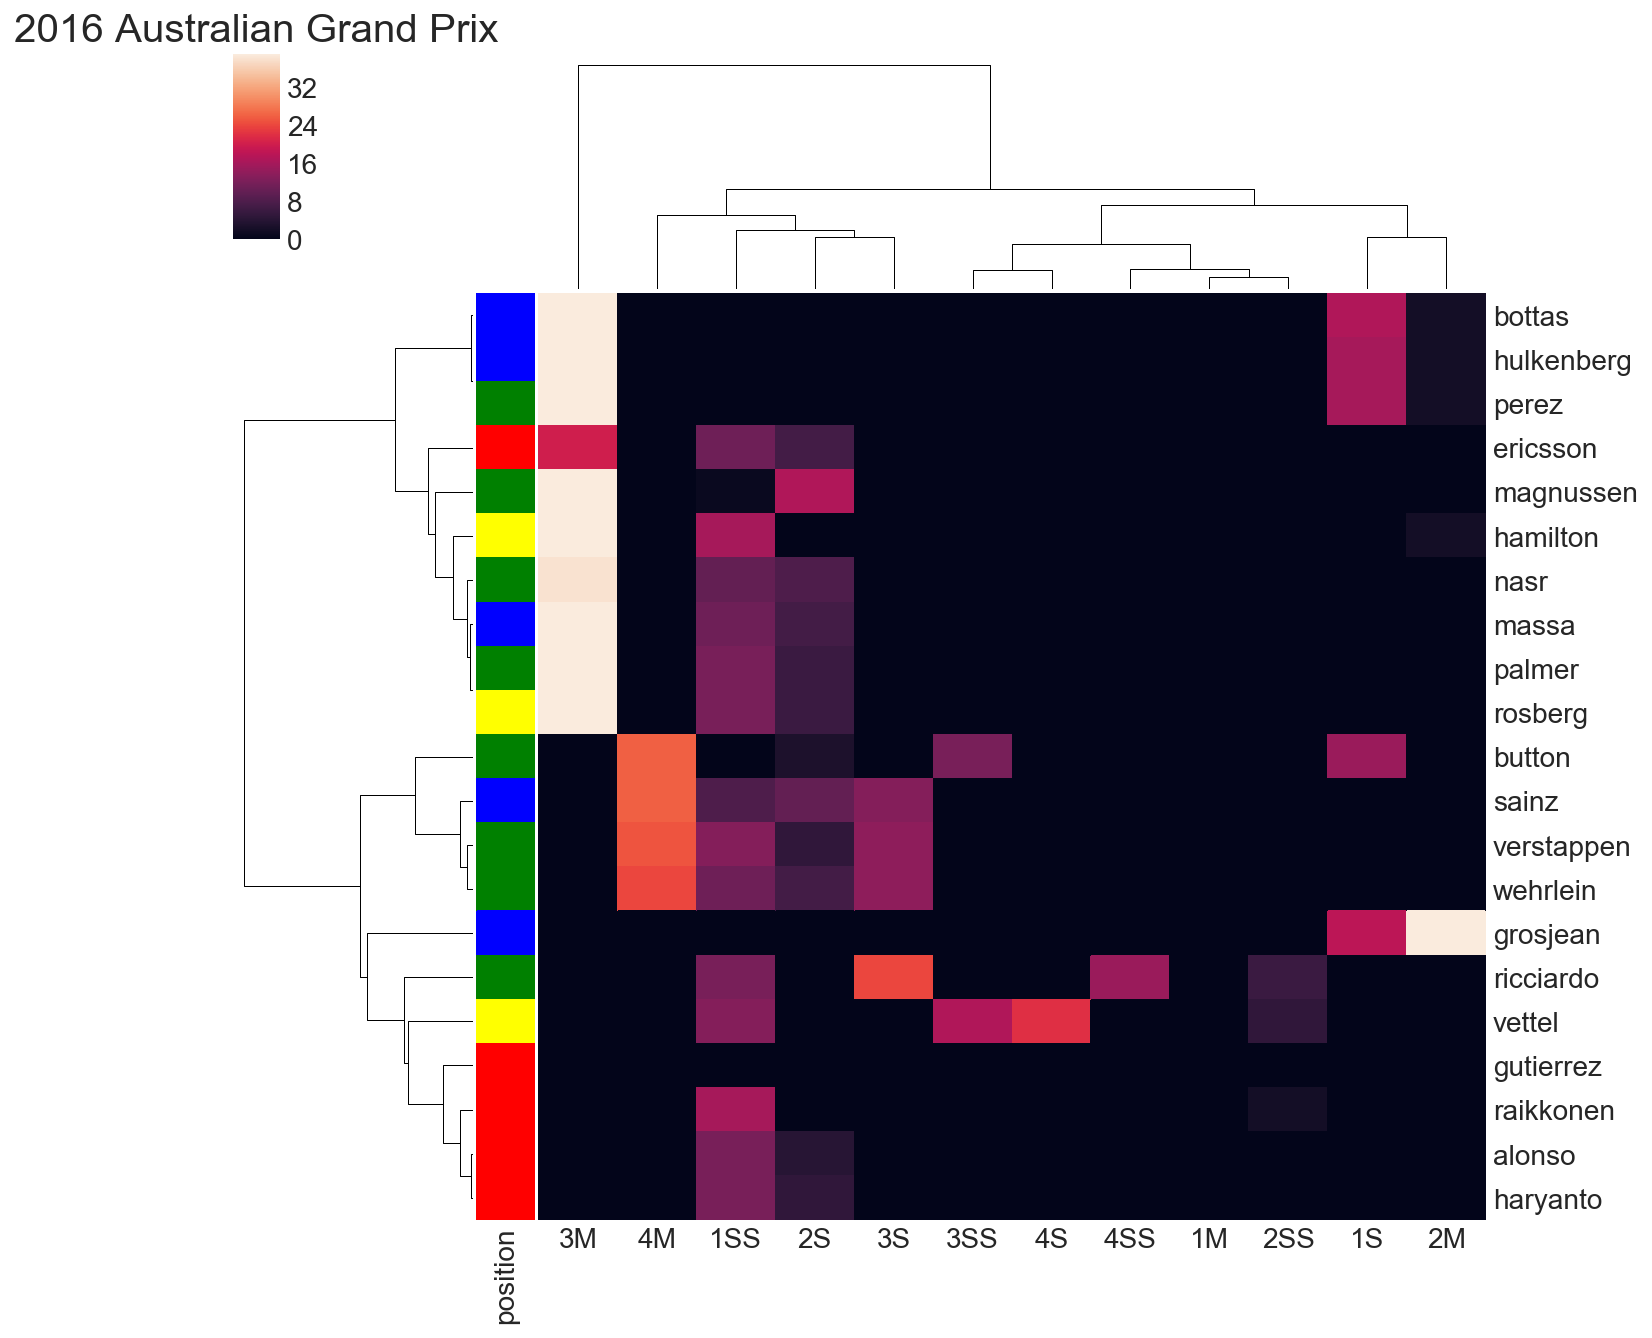

In [30]:
plot_clustermap(aus, '2016 Australian Grand Prix', 'aus_clustermap.png')

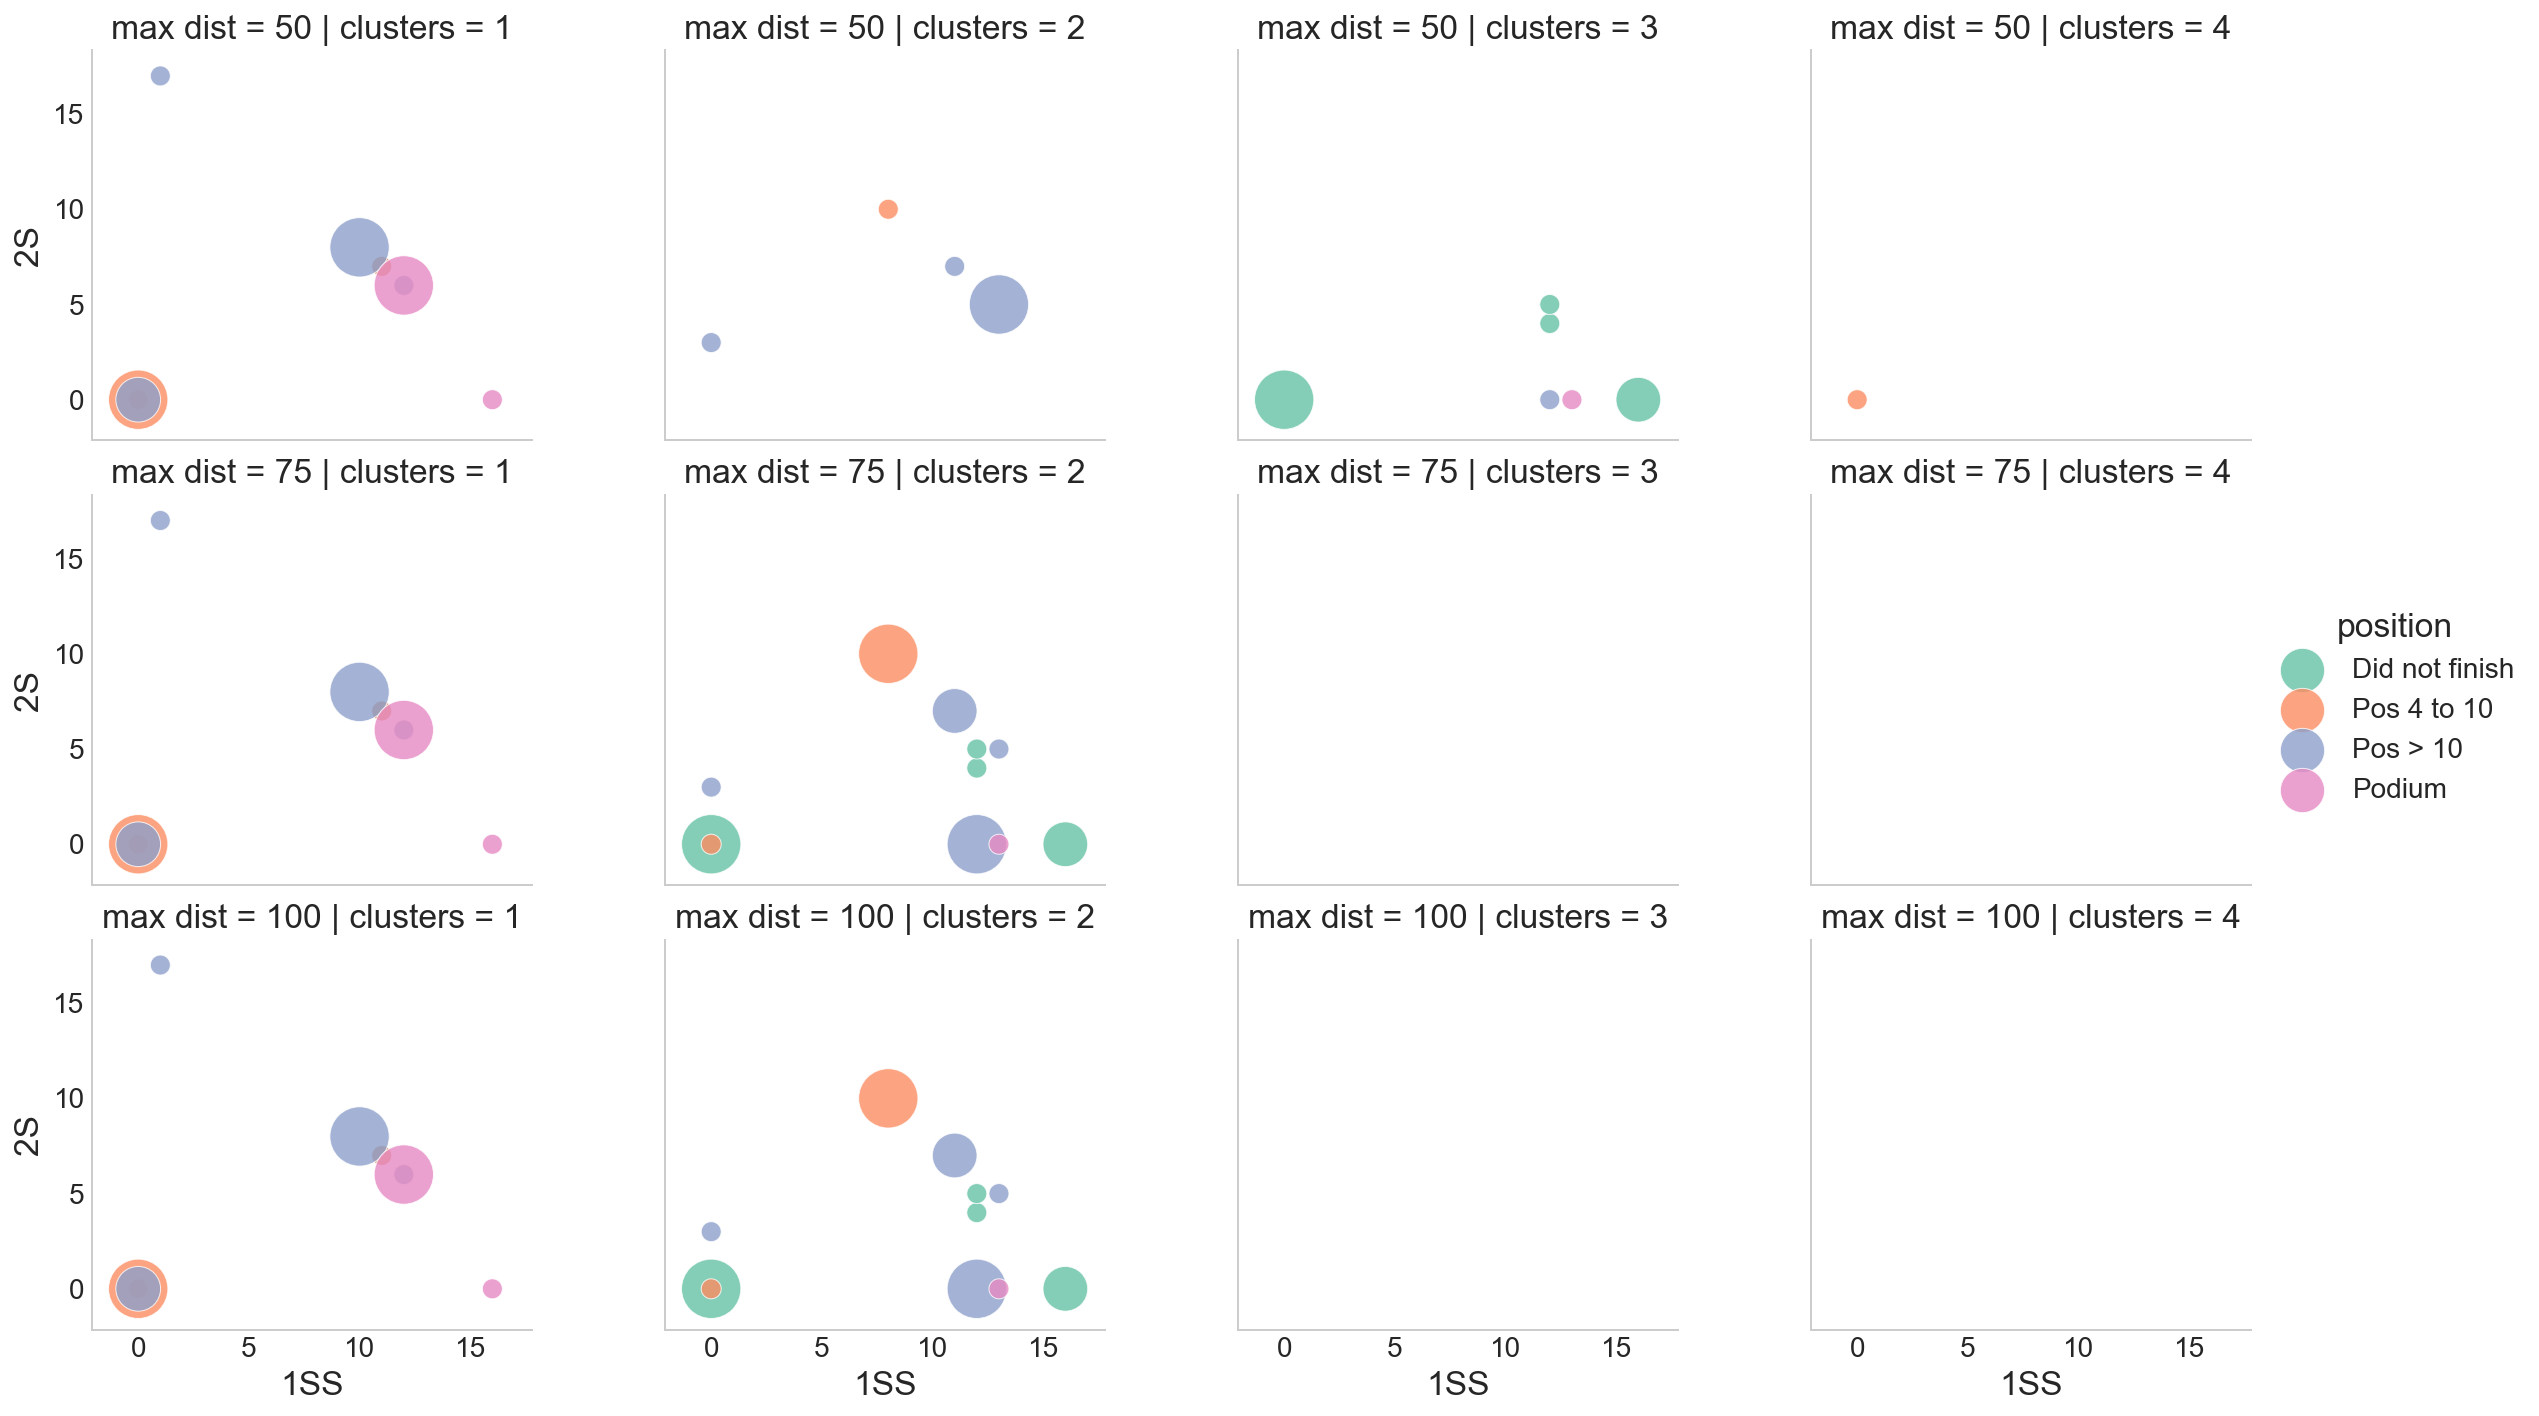

In [37]:
plot_clusters(df=df_aus, row='max dist', col='clusters', scatter_x=SS[0], scatter_y=S[1],
              hue='position', col_for_s=M[2], filename='aus_clusters.png')

#### eg. 2016 Azerbaijan Grand Prix

In [38]:
aze = dr_stint[(dr_stint['year'] == 2016) & (dr_stint['name'] =='Azerbaijan Grand Prix')]\
      [index_list+ cat1+['position', 'constructorRef']].reset_index(drop=True)
aze

,year,driverRef,name,1SS,1S,1M,2SS,2S,2M,3SS,3S,3M,4SS,4S,4M,position,constructorRef
0,2016,alonso,Azerbaijan Grand Prix,5.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Did not finish,mclaren
1,2016,bottas,Azerbaijan Grand Prix,19.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pos 4 to 10,williams
2,2016,button,Azerbaijan Grand Prix,6.0,0.0,0.0,0.0,19.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,Pos > 10,mclaren
3,2016,ericsson,Azerbaijan Grand Prix,0.0,16.0,0.0,9.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,Pos > 10,sauber
4,2016,grosjean,Azerbaijan Grand Prix,10.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,Pos > 10,haas
5,2016,gutierrez,Azerbaijan Grand Prix,8.0,0.0,0.0,0.0,21.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,Pos > 10,haas
6,2016,hamilton,Azerbaijan Grand Prix,15.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pos 4 to 10,mercedes
7,2016,haryanto,Azerbaijan Grand Prix,1.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pos > 10,manor
8,2016,hulkenberg,Azerbaijan Grand Prix,0.0,20.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pos 4 to 10,force_india
9,2016,kvyat,Azerbaijan Grand Prix,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Did not finish,toro_rosso


In [39]:
max_dist = [50,75,100]
df_aze = pd.DataFrame()
report_aze = pd.DataFrame()
for i in max_dist:
    df_report, df_clusters = get_clusters(aze, index_list, max_dist=i)
    df_aze = pd.concat([df_aze, df_clusters])
    report_aze = pd.concat([report_aze, df_report])

In [40]:
report_aze

,Number of clusters,c,max dist
0,5,0.68588,50
0,2,0.68588,75
0,1,0.68588,100


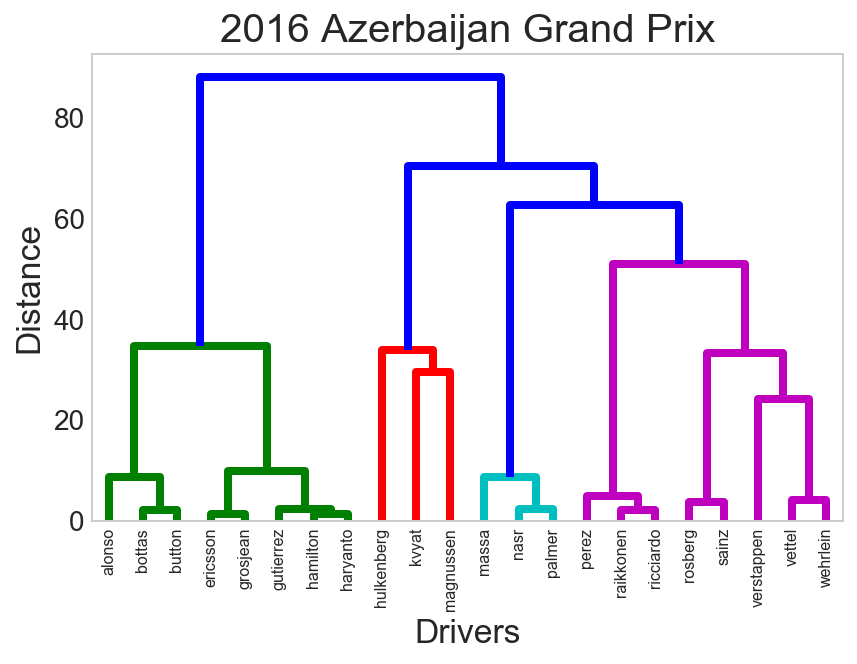

In [42]:
plot_dendogram(aze, '2016 Azerbaijan Grand Prix', 'aze_dendrogram.png')

{'Podium': 'yellow', 'Pos 4 to 10': 'blue', 'Pos > 10': 'green', 'Did not finish': 'red'}


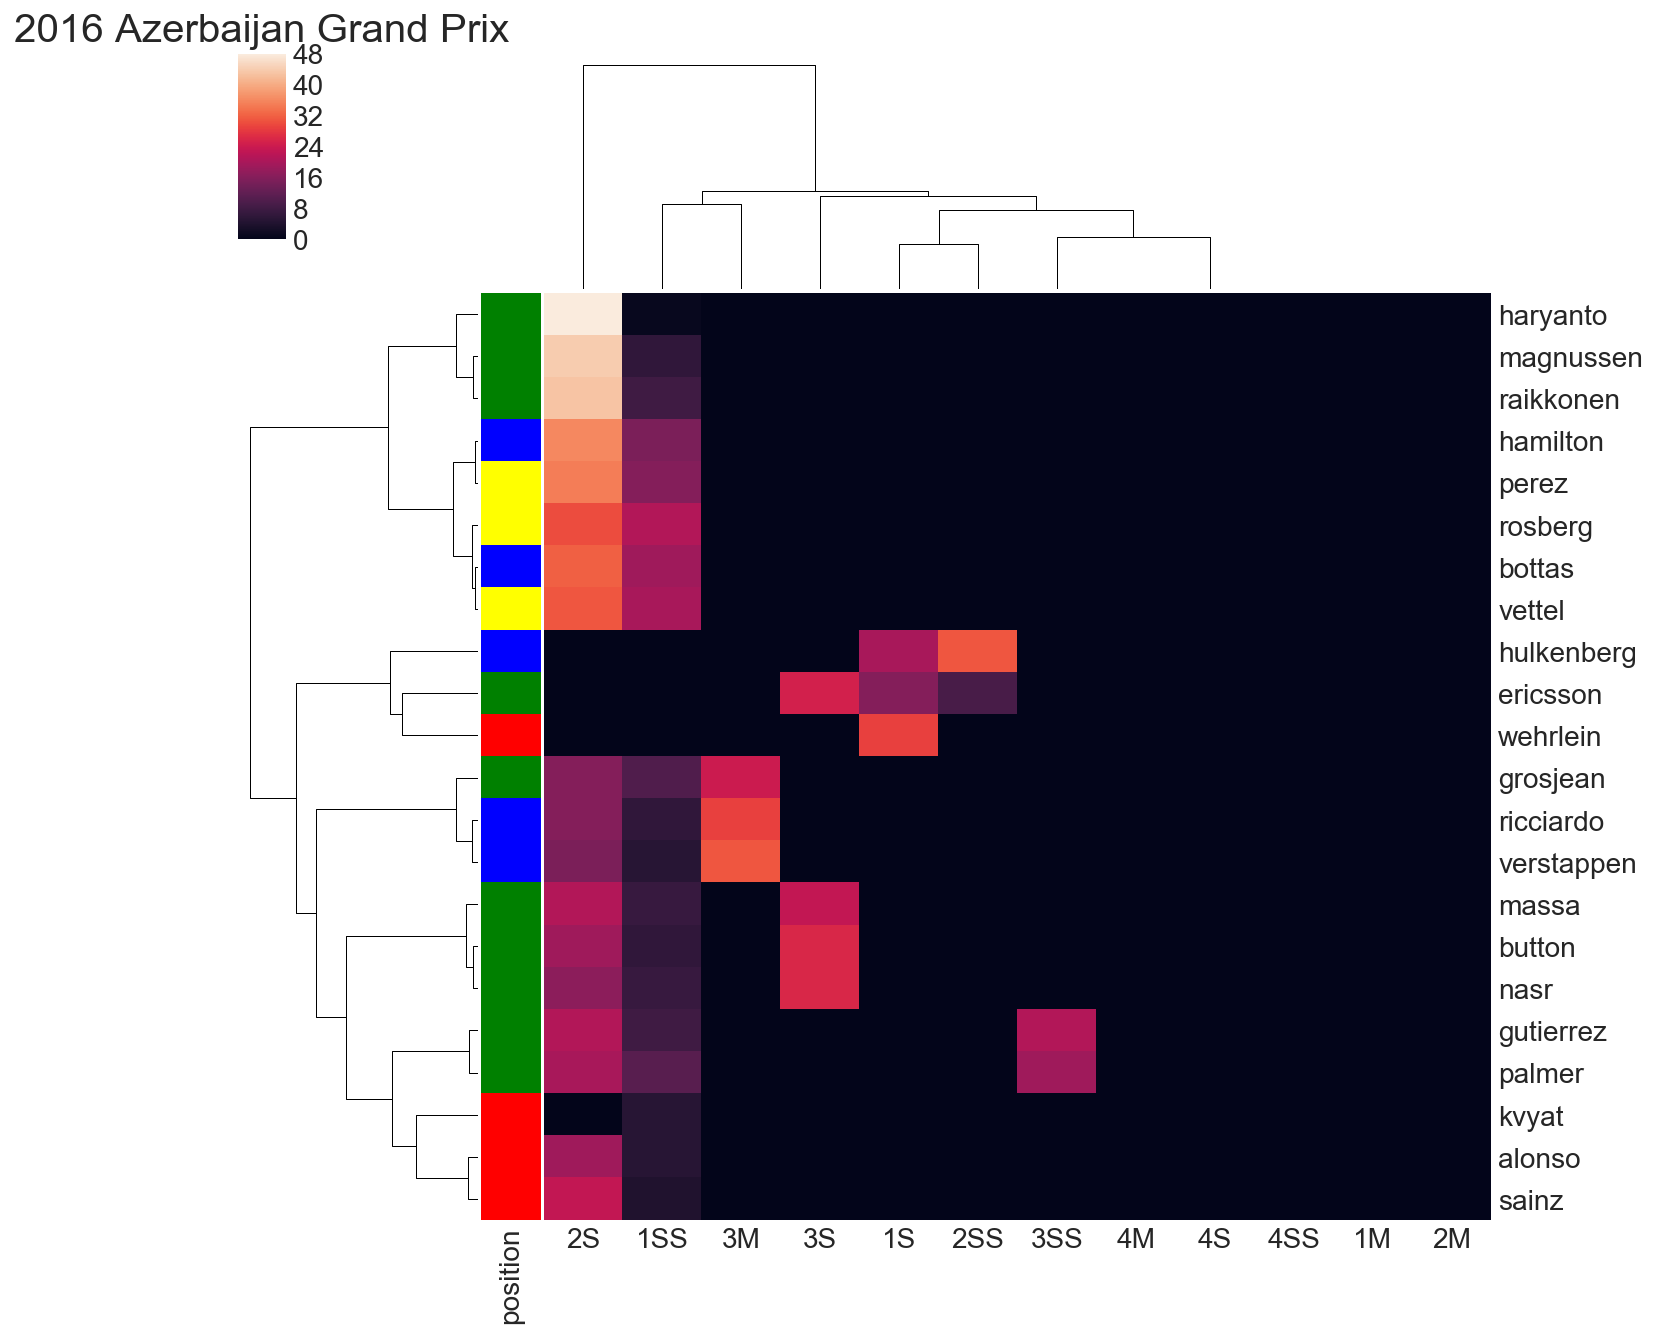

In [43]:
plot_clustermap(aze, '2016 Azerbaijan Grand Prix', 'aze_clustermap.png')

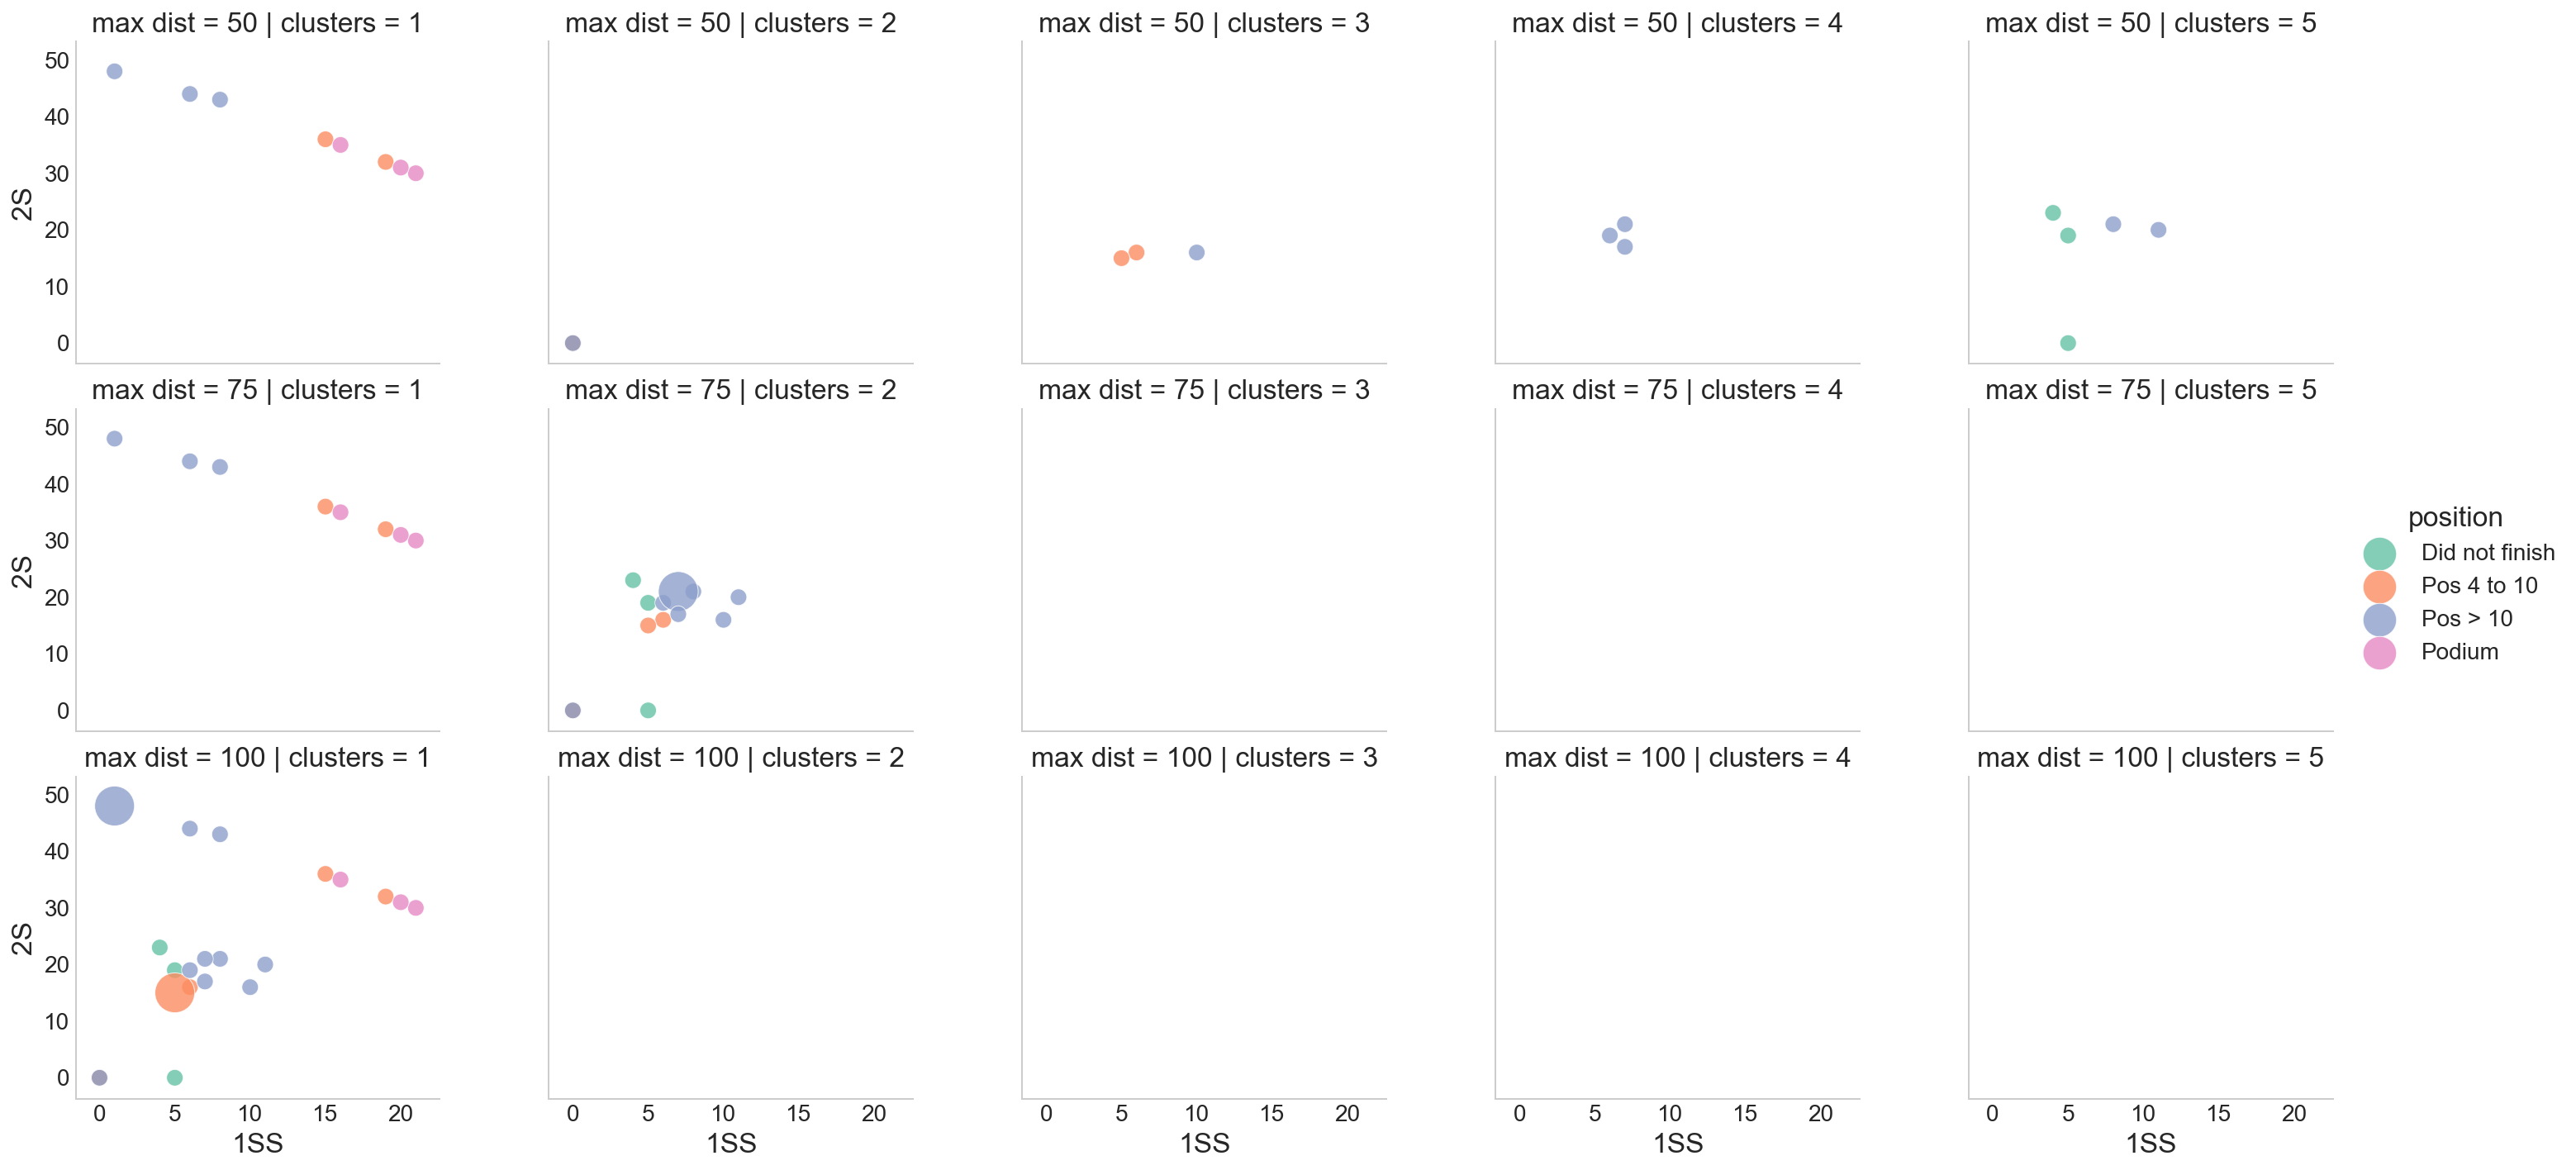

In [44]:
plot_clusters(df=df_aze, row='max dist', col='clusters', scatter_x=SS[0], scatter_y=S[1],
              hue='position', col_for_s=M[2], filename='aze_clusters.png')

### Visualize relationship between distance threshold and number of clusters

<Figure size 720x1152 with 0 Axes>

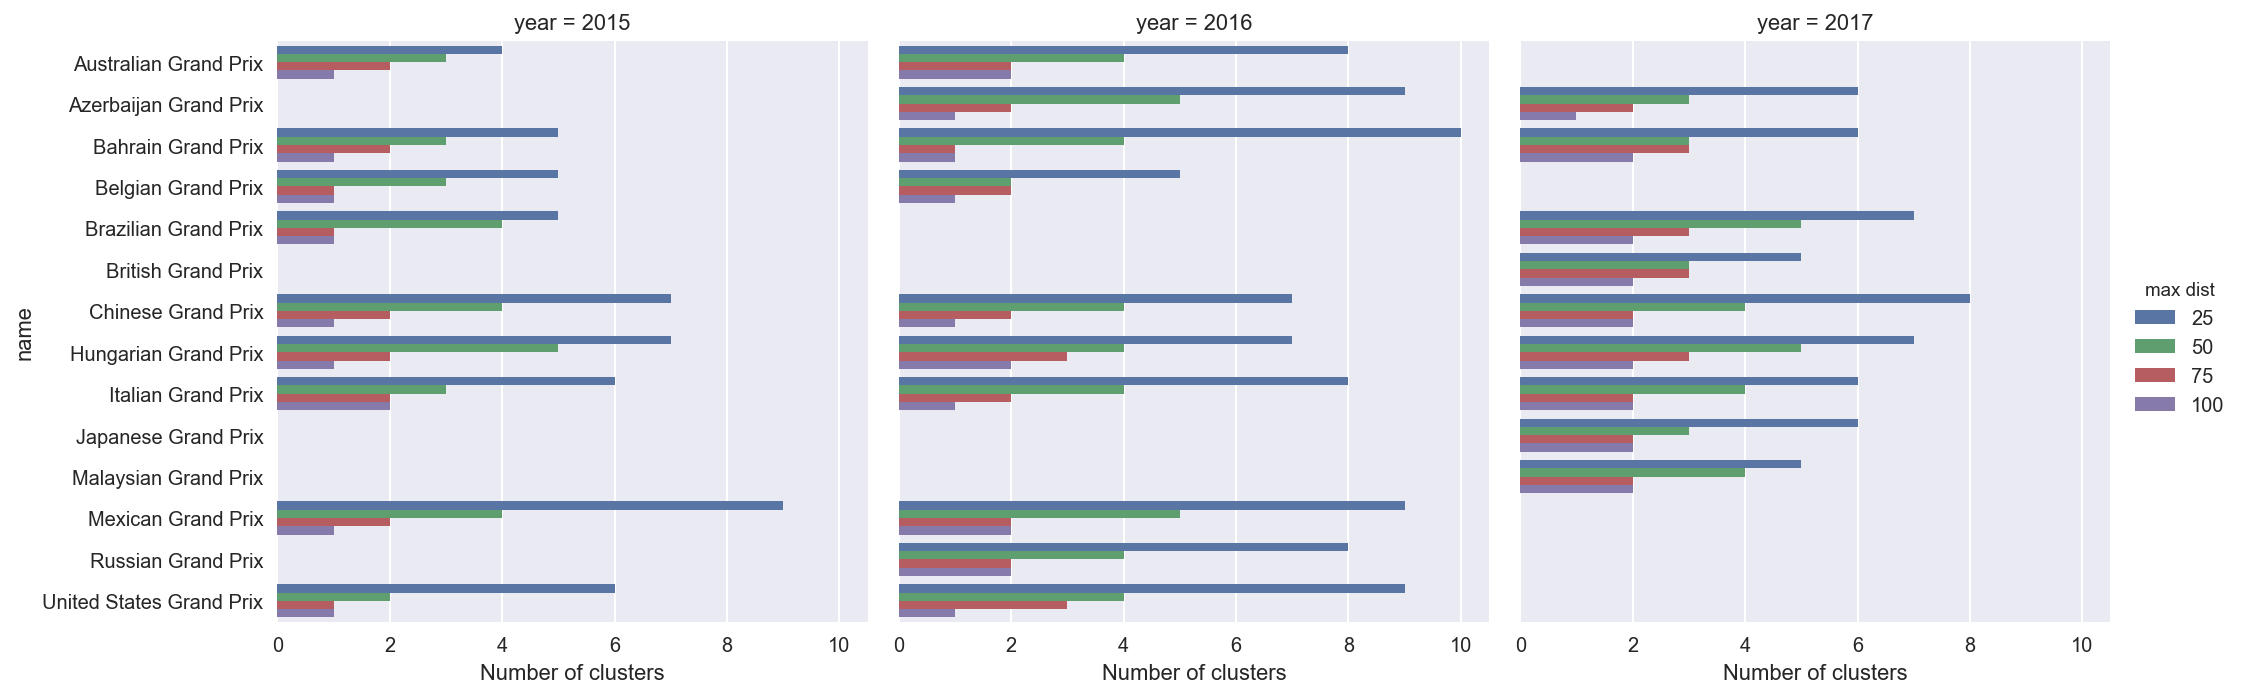

In [36]:
plt.figure(figsize=(10,16))
sns.set(font_scale=1)
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat1, size=5, aspect=1)
g.savefig(directory+'cat1_clusters.png')

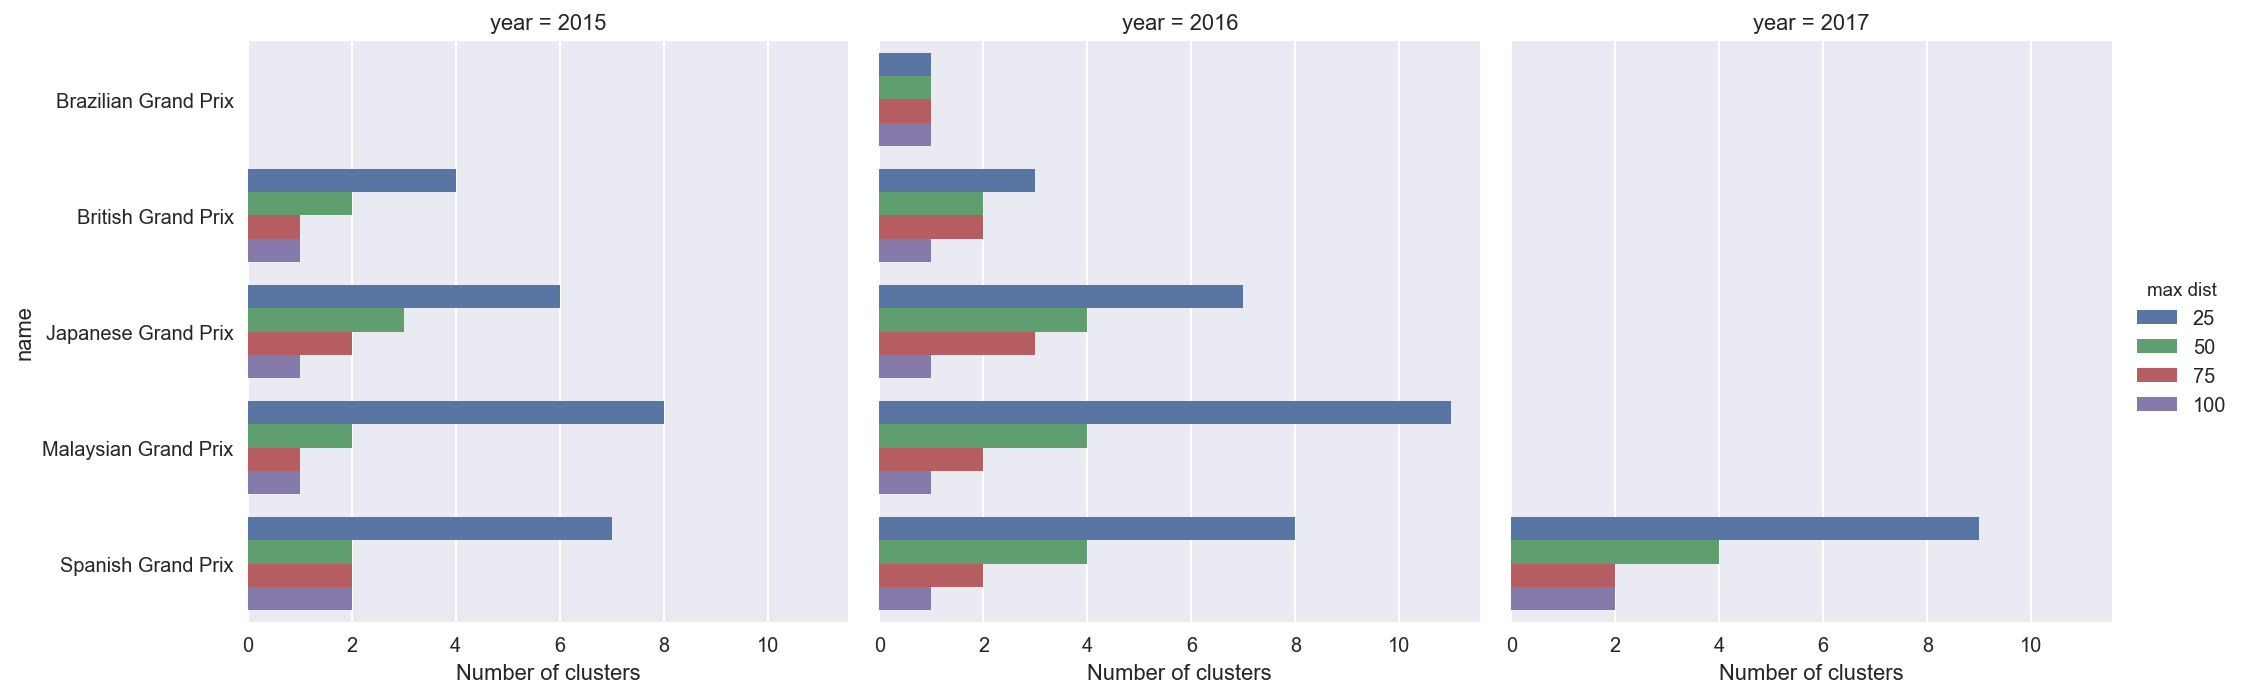

In [37]:
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat2, size=5, aspect=1)
g.savefig(directory+'cat2_clusters.png')

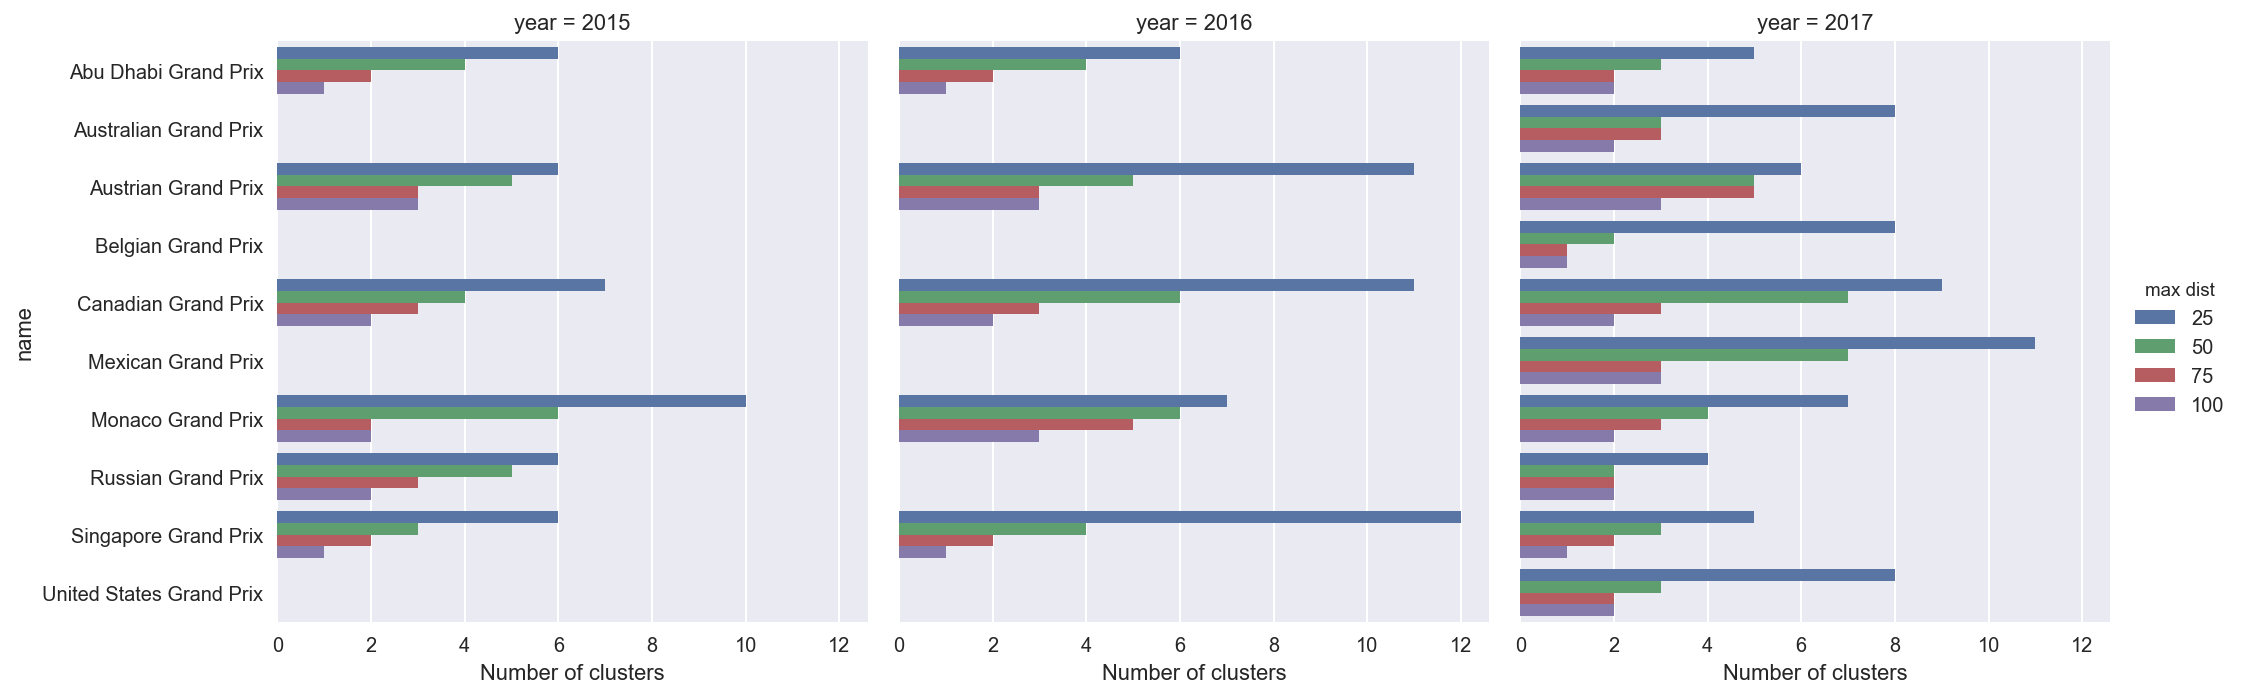

In [38]:
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat3, size=5, aspect=1)
g.savefig(directory+'cat3_clusters.png')

### Visualize relationship between clusters and drivers

In [139]:
def scatter_plot(df):
    
    year = [2015, 2016, 2017]

    for i in year:
        lm = sns.lmplot(x='driverRef', y='clusters', data=df[(df['year'] == i)], hue='name', 
                        y_jitter=0.2, palette='Set1', size=6, aspect=2.5,
                        fit_reg=False, scatter_kws={"s": 90})
        lm.set_xticklabels(rotation=45)
        fig = lm.fig 
        fig.suptitle('Year: '+ str(i) + ' Pirelli Category: ' + str(df['pirelli category'].unique()), fontsize=18)
        
        i = 0
        while os.path.exists('{}{:d}.png'.format("scatter_plot_clusters_", i)):
            i += 1
        fig.savefig('{}{:d}.png'.format("scatter_plot_clusters_", i), bbox_inches='tight', facecolor='w', transparent=False, pad_inches = 0.5)


In [137]:
def plot_loop(dfs, dataset, index_list, max_dist):
    df_all = pd.DataFrame()
    for i in dfs:
        i.sort_values('constructorRef', ascending=True, inplace=True)
        df = i[i['max dist'] == max_dist].reset_index(drop=True)
        df_all = pd.concat([df_all, df])
        scatter_plot(df)
    return df_all

In [43]:
sns.set(rc={"font.style":"normal",
            "axes.facecolor":(0.9, 0.9, 0.9),
            "figure.facecolor":'white',
            'axes.labelsize':16,
            'xtick.labelsize':14,
            'ytick.labelsize':14})

sns.set_style("whitegrid", {'axes.grid' : False})

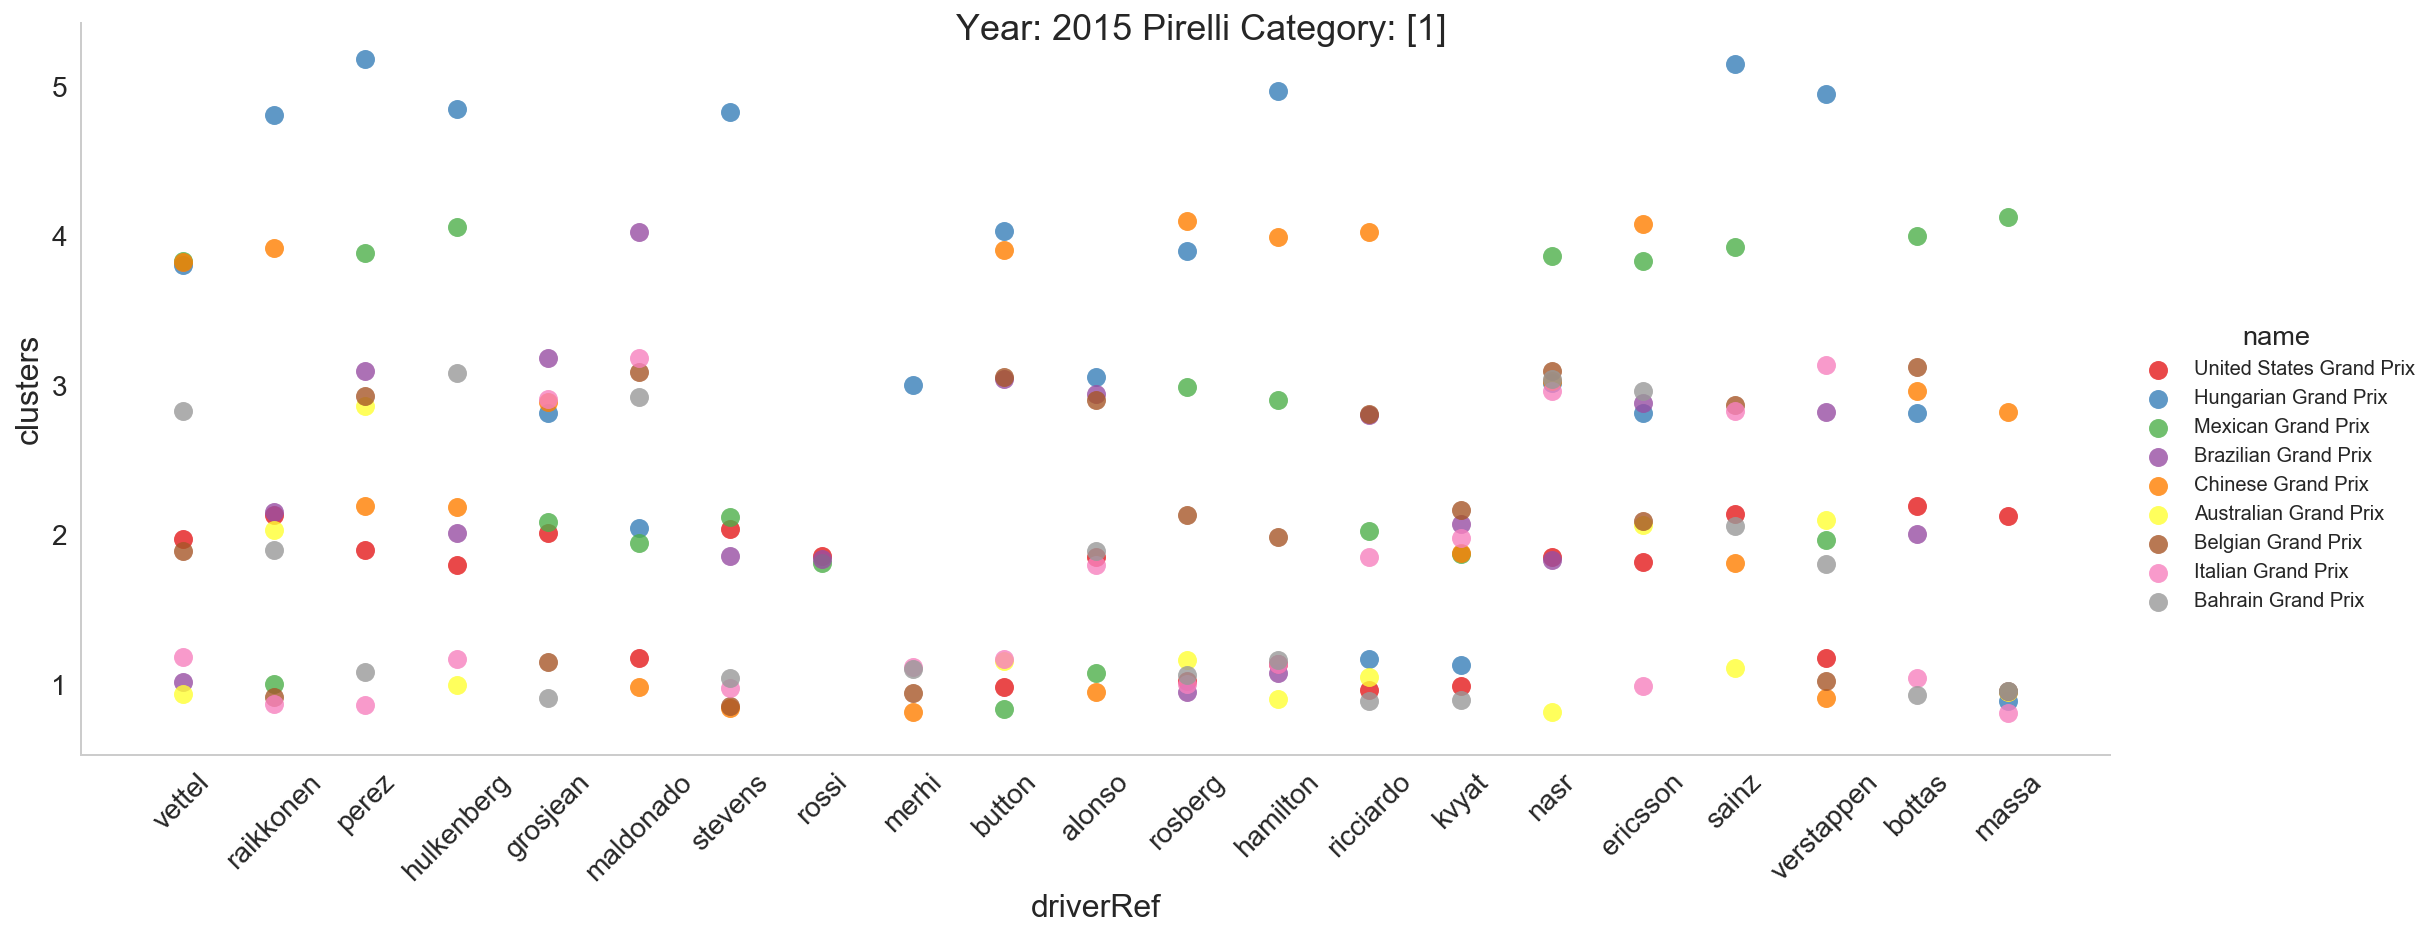

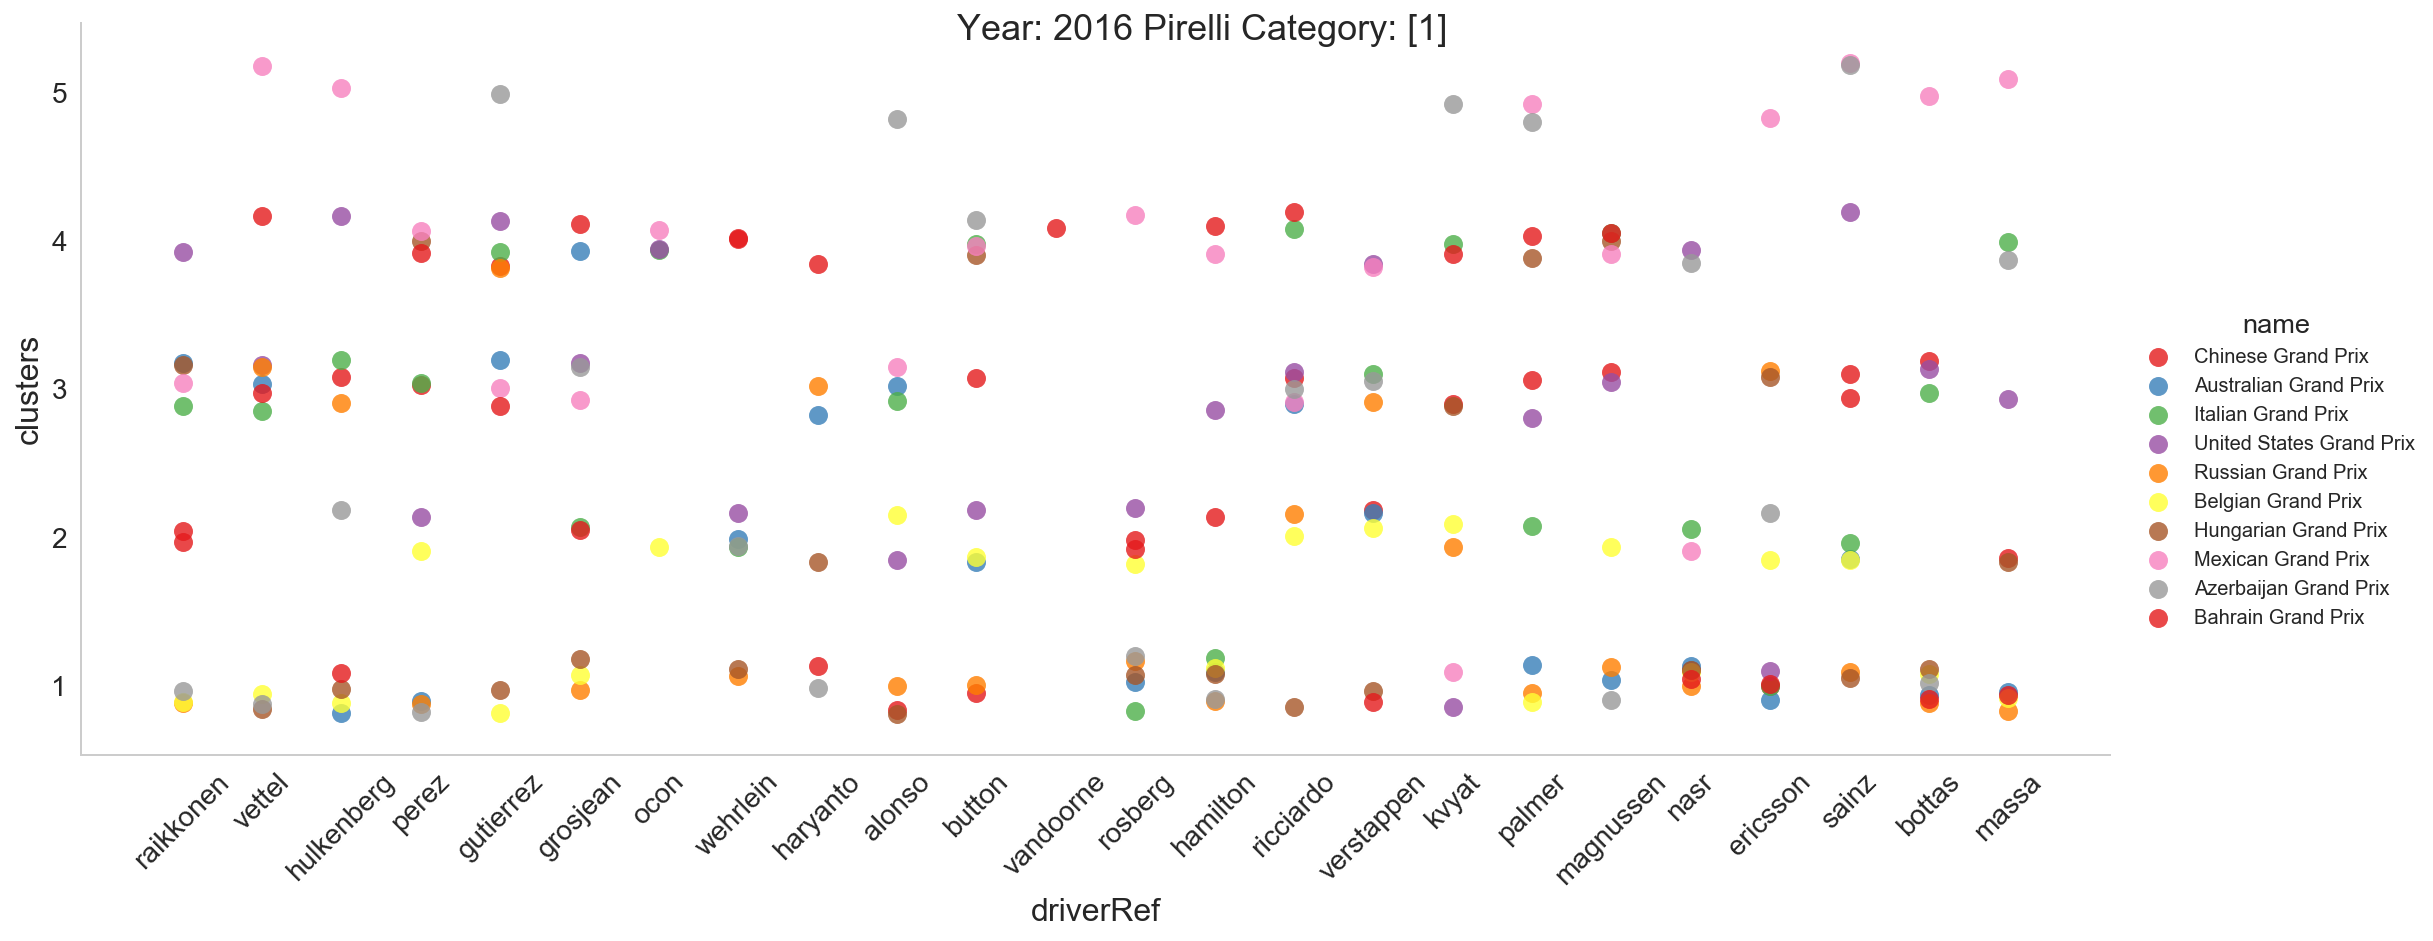

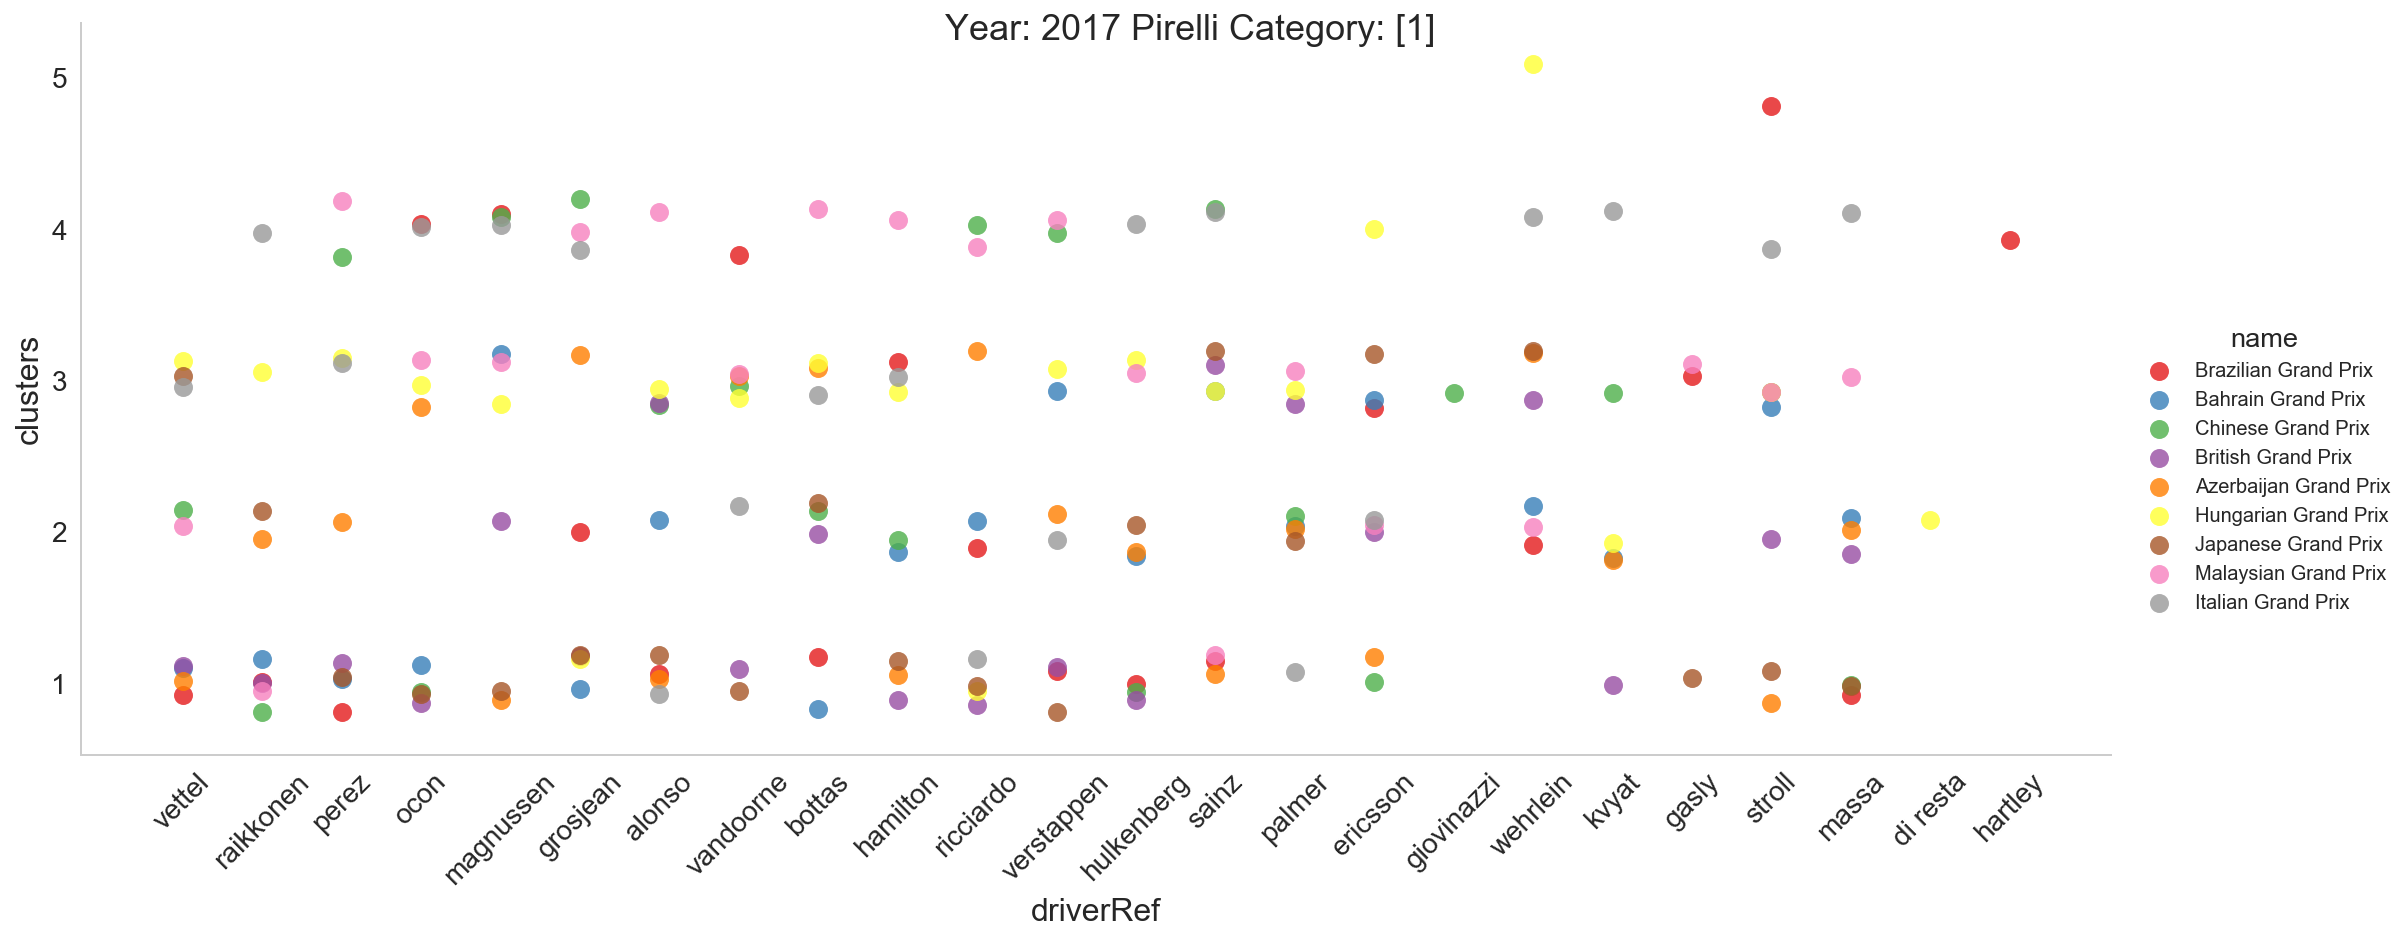

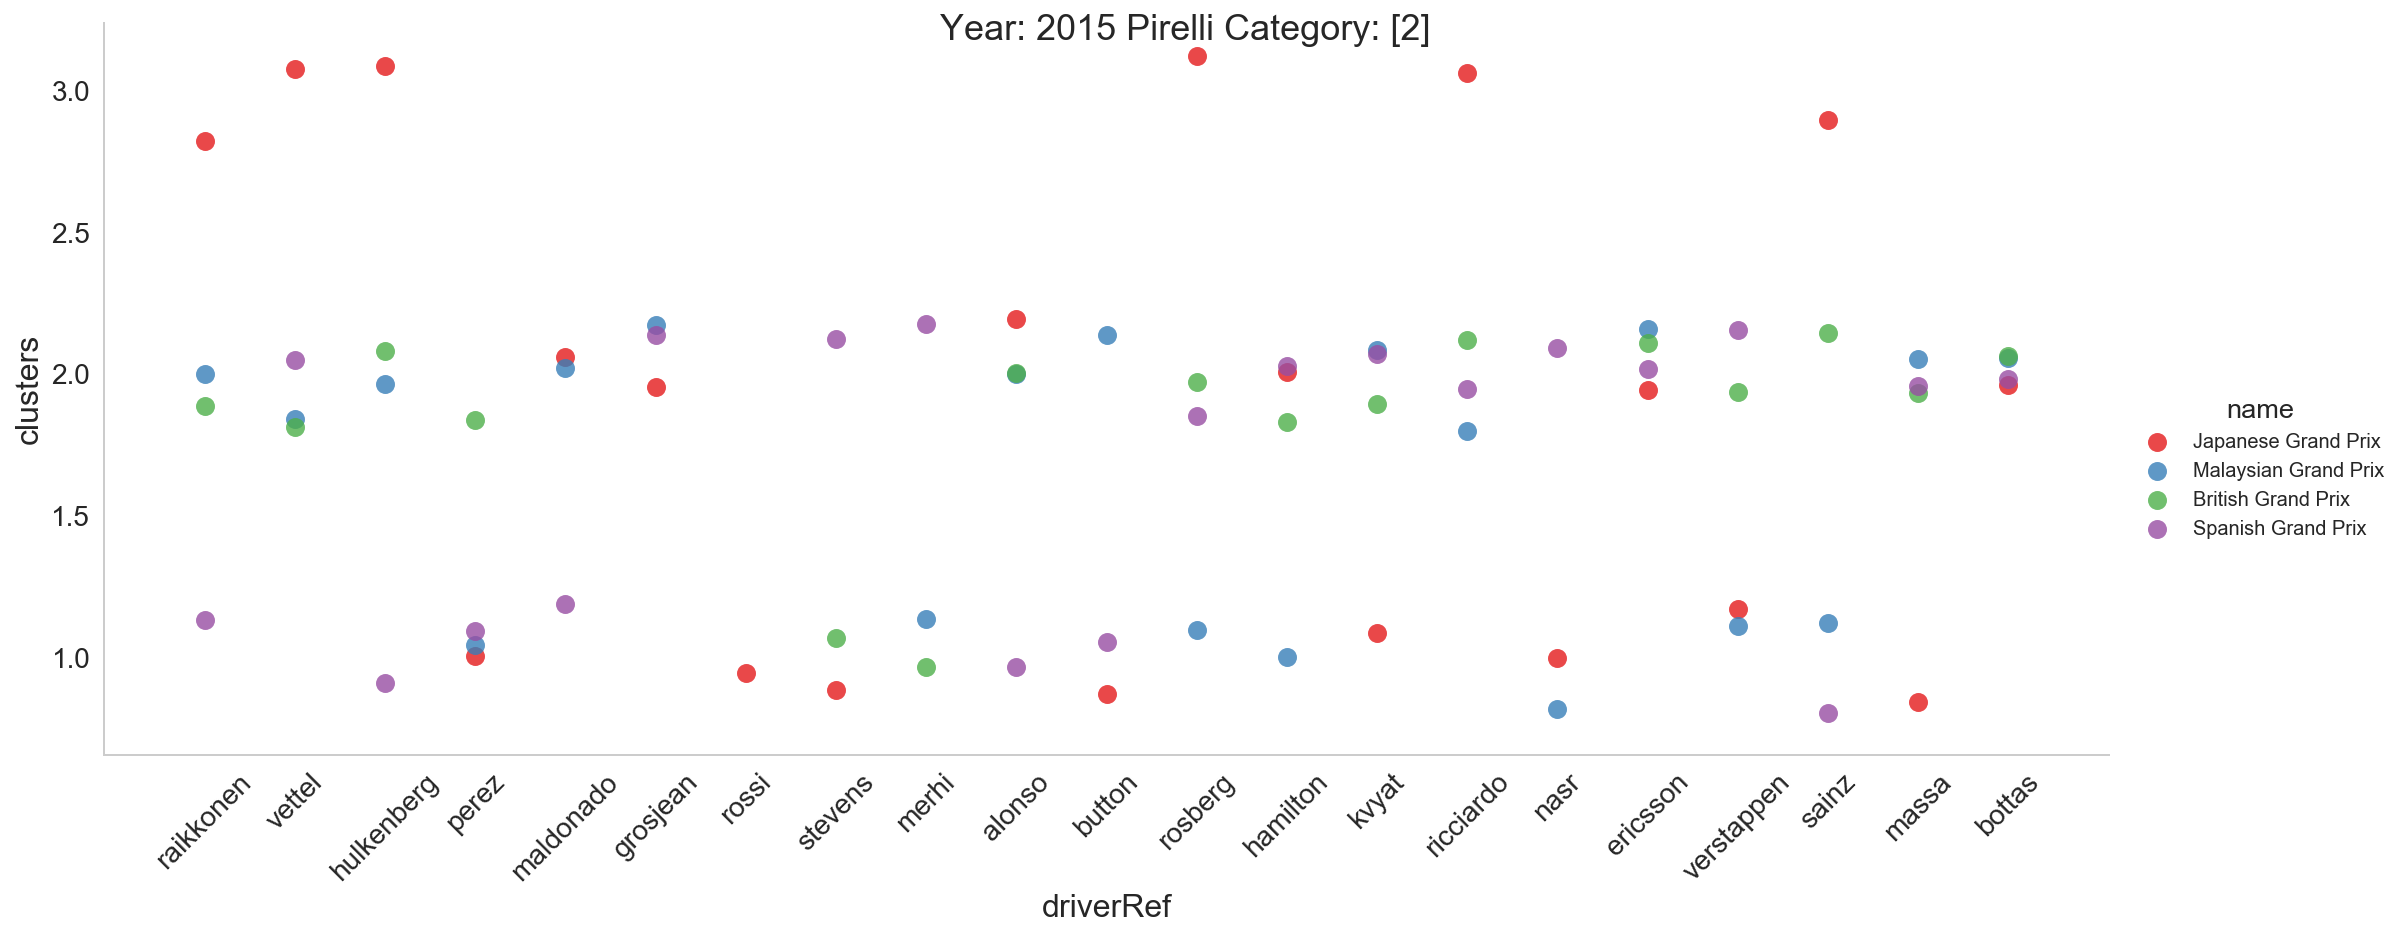

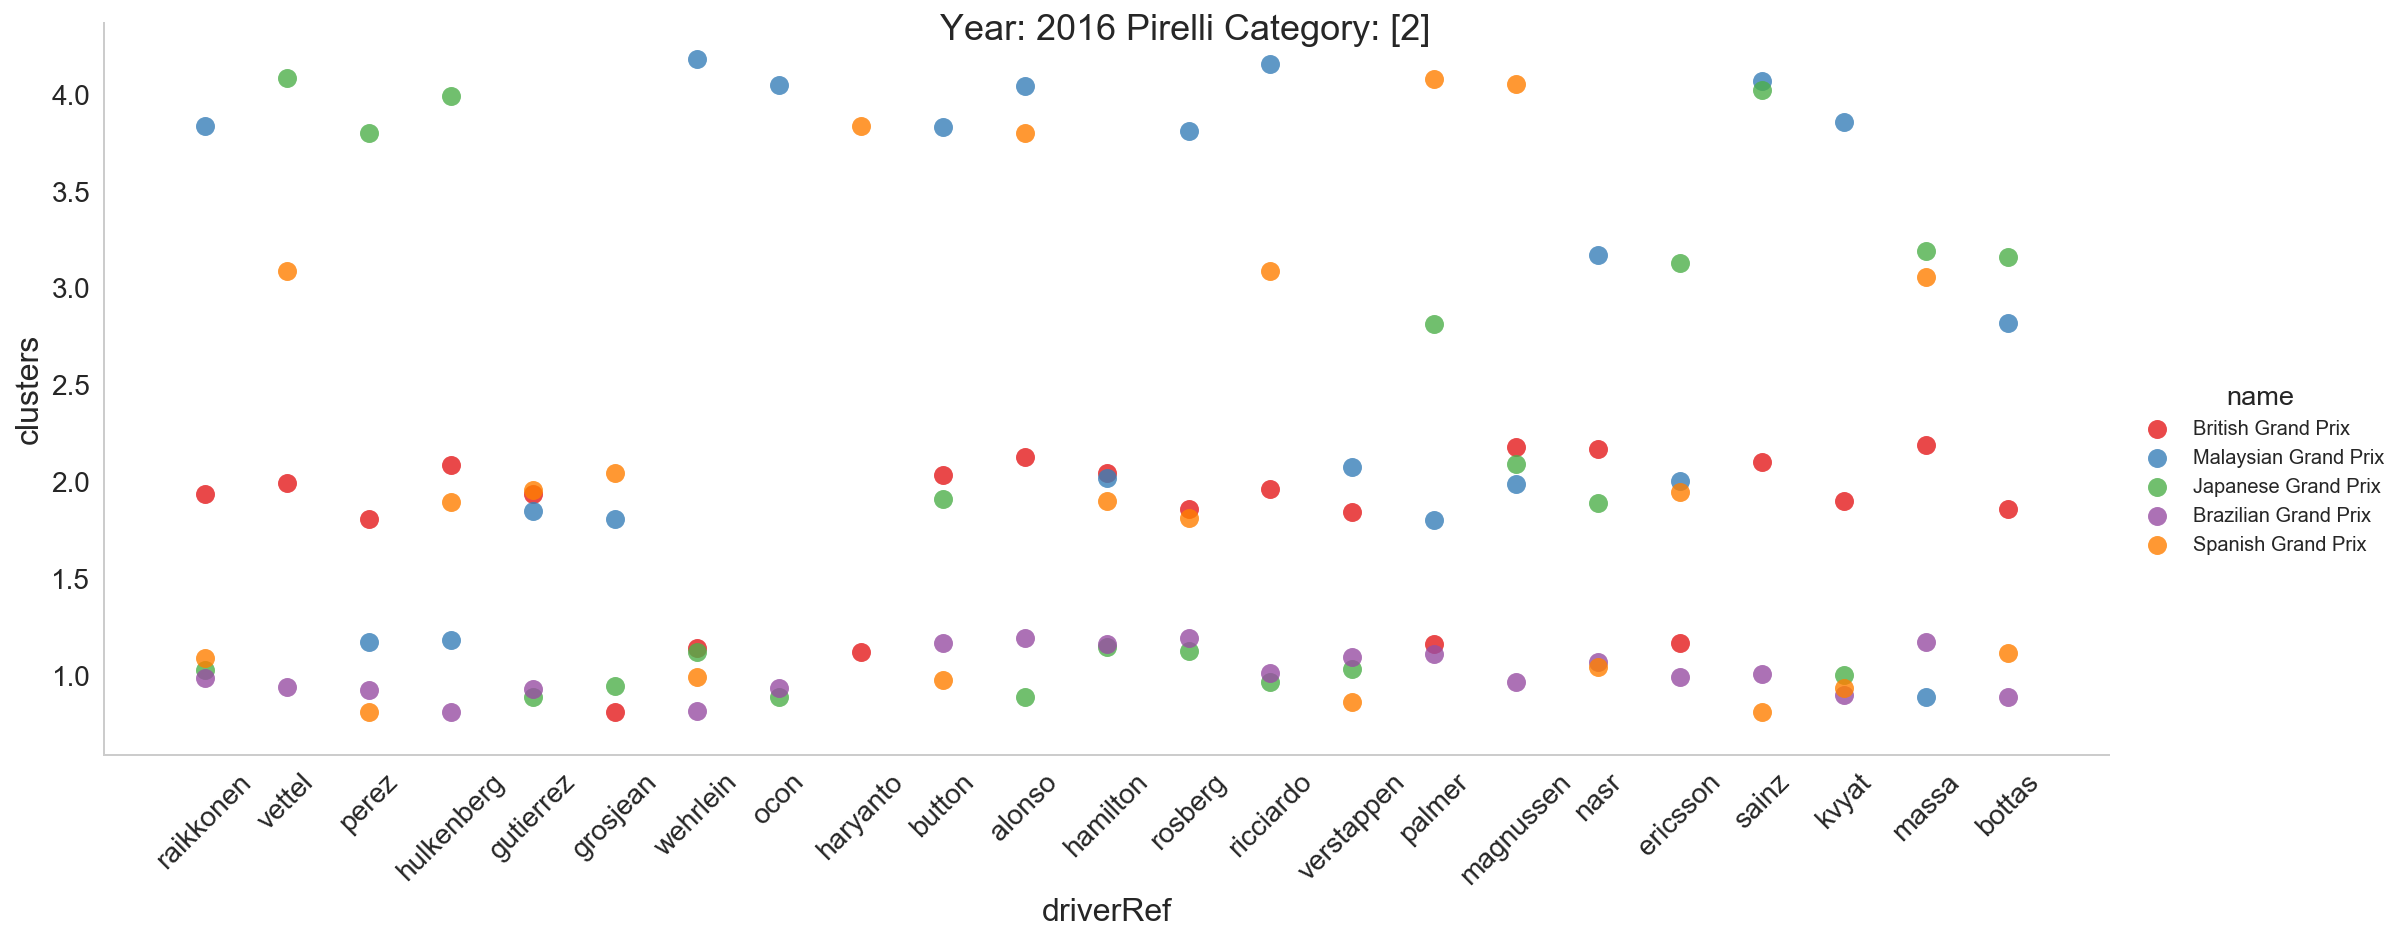

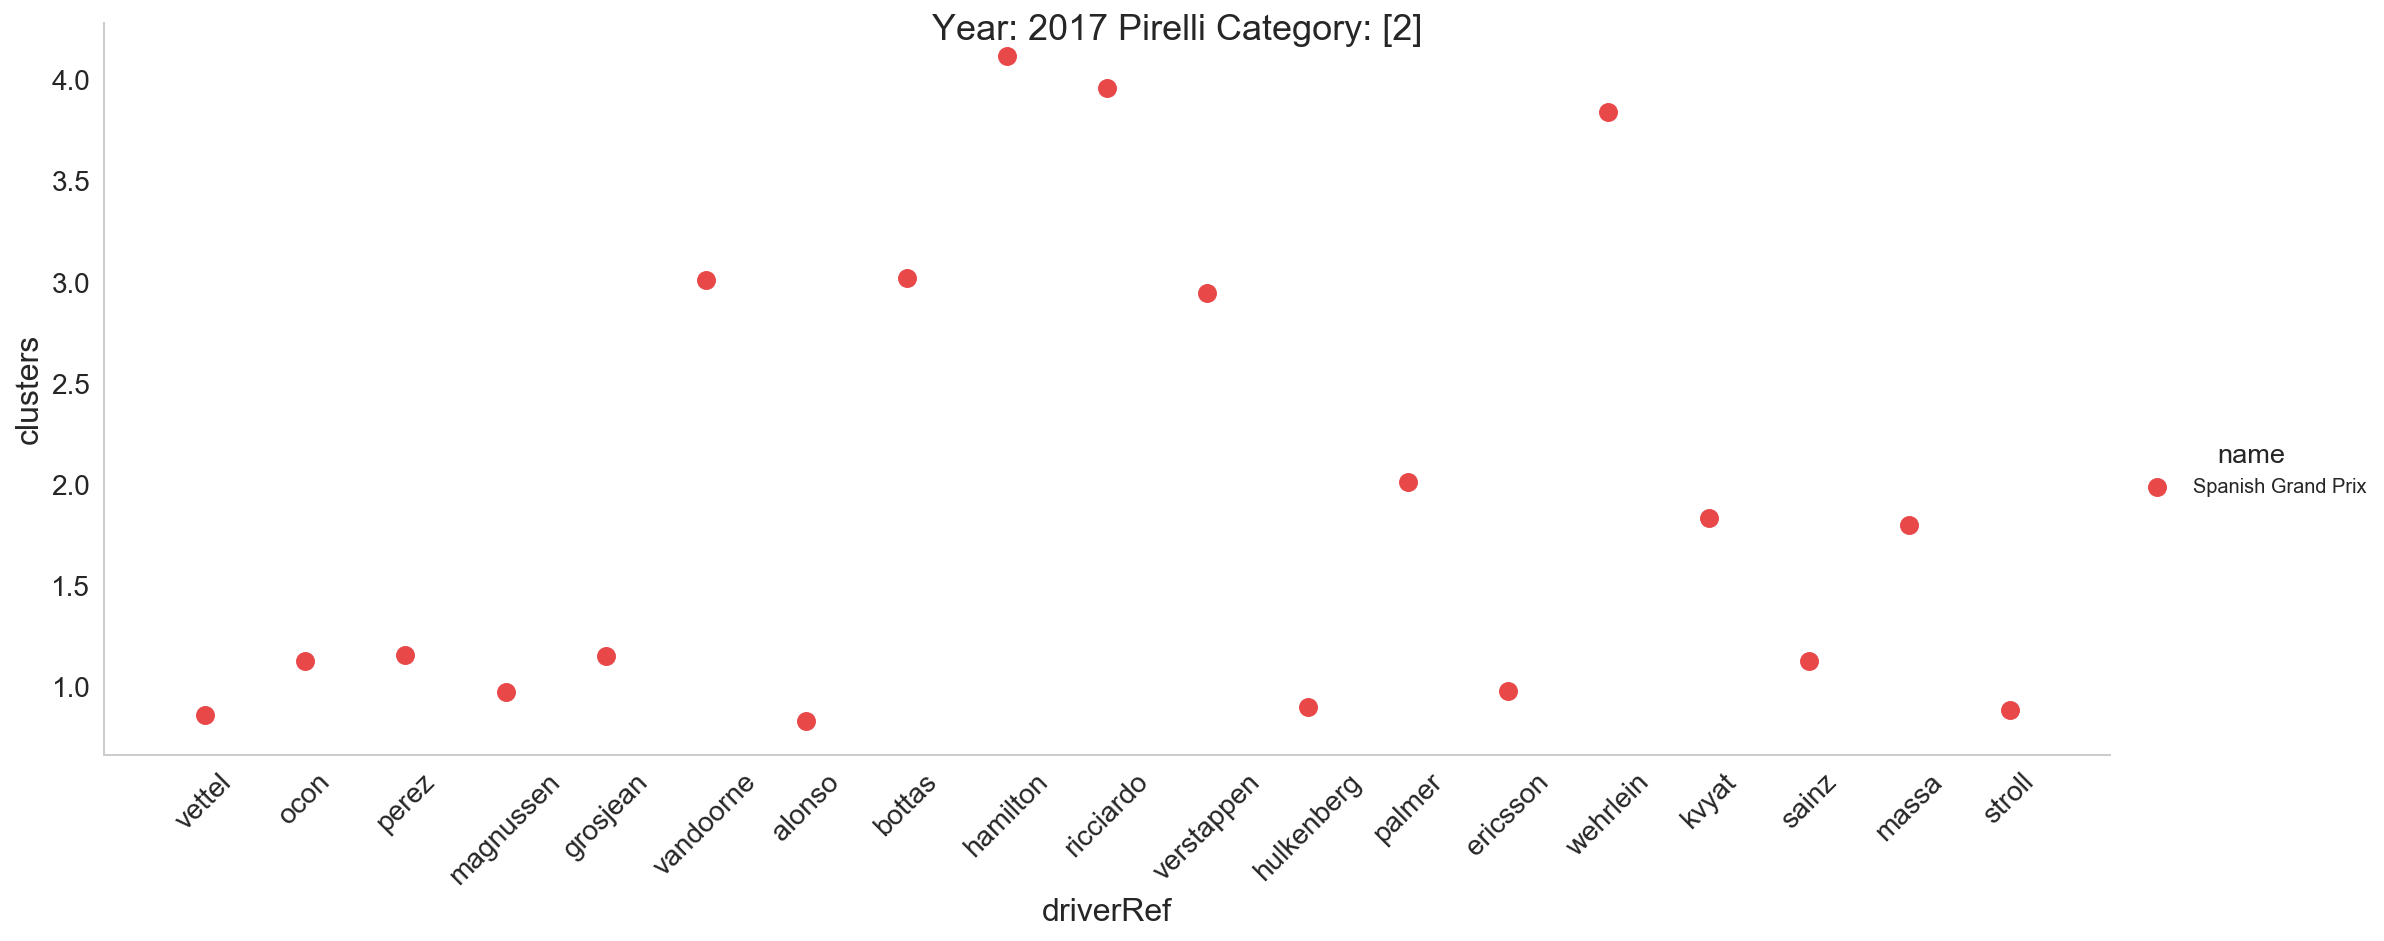

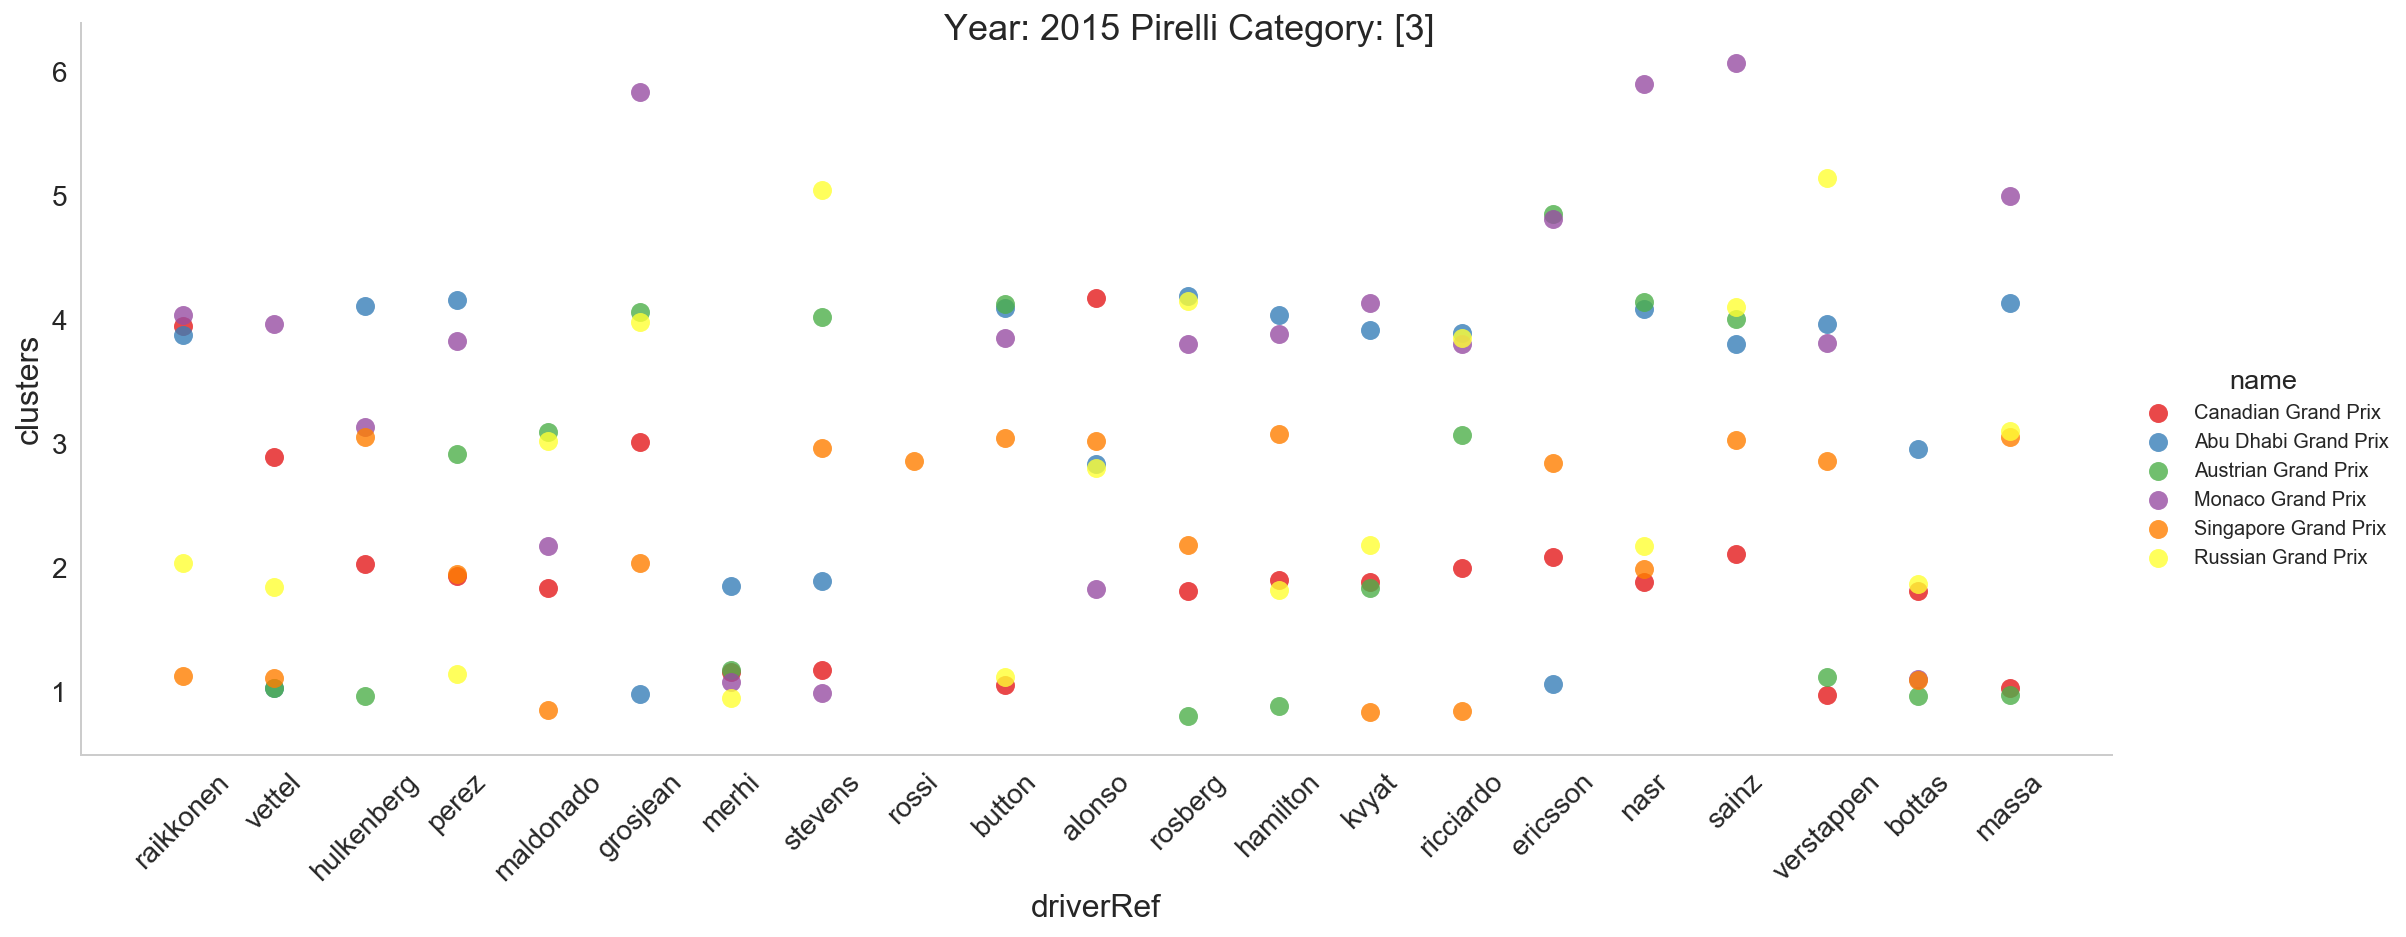

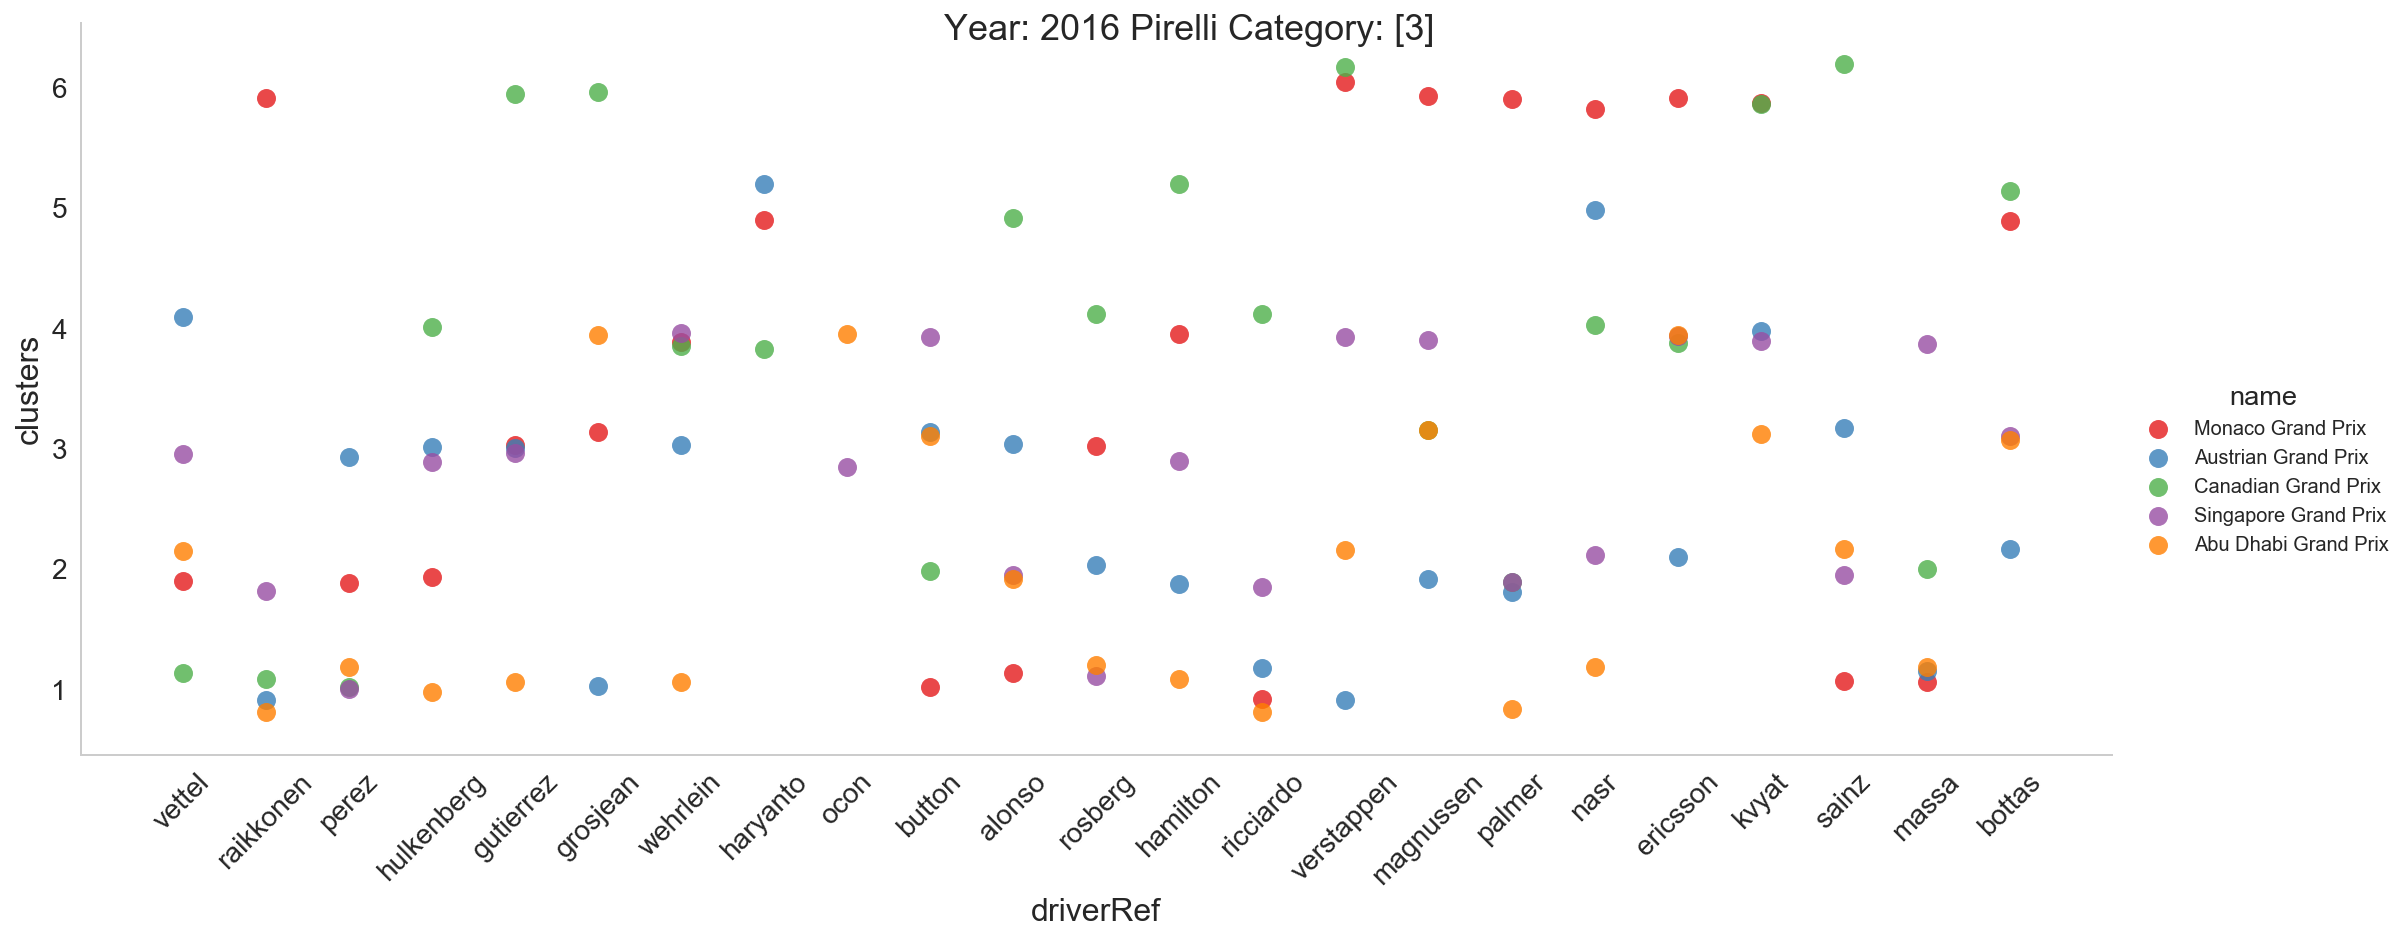

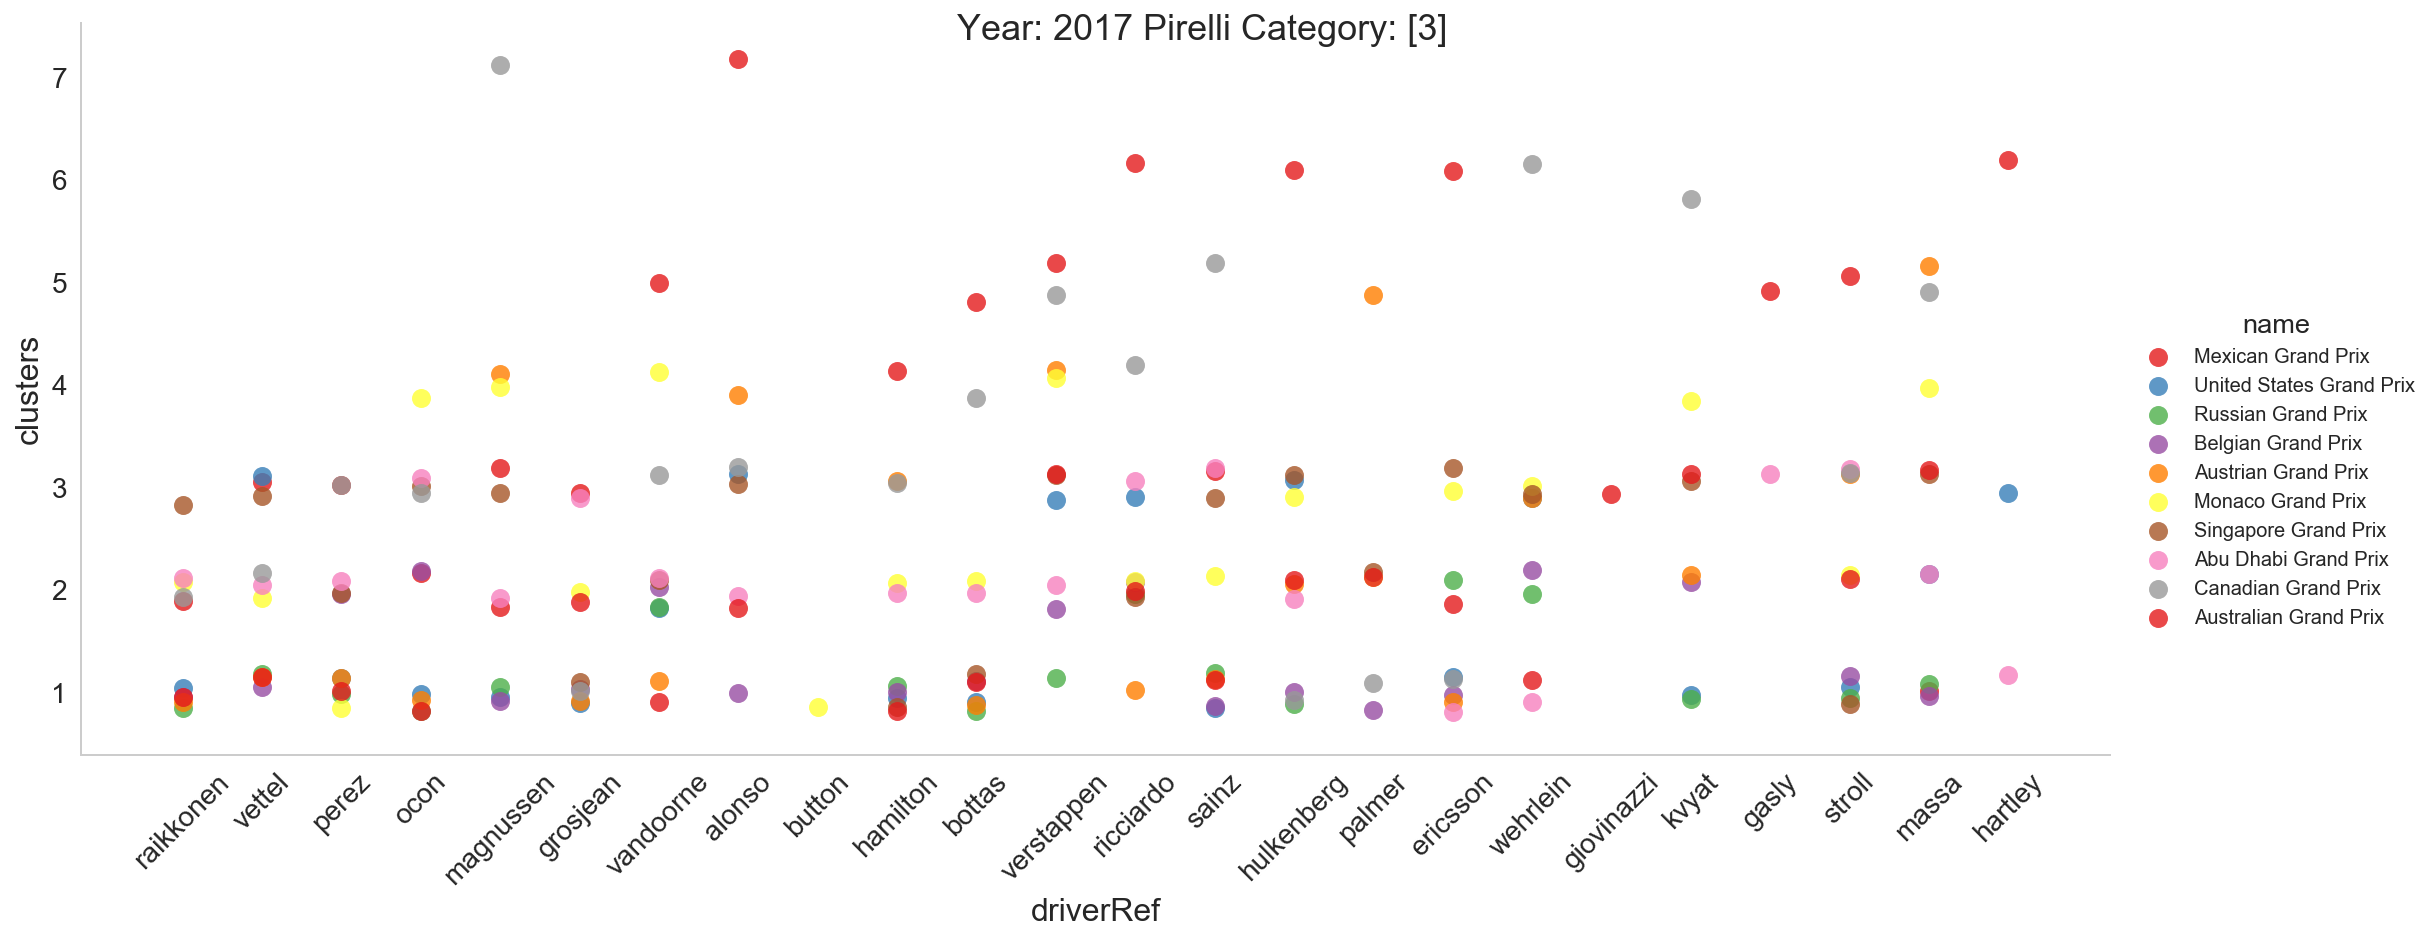

In [140]:
dfs = [df_clusters_cat1, df_clusters_cat2, df_clusters_cat3]
df_all = plot_loop(dfs, dataset, index_list, max_dist=50)